# Explore luminosity (without K-corrections) combinations

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy.table import Table
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
# from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn import preprocessing
from datetime import date
import getpass
import progressbar
import pandas as pd
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

In [4]:
gamma_alex  = 2.0  # From Alexander+2003 (photon index for X-Rays)

In [5]:
gamma_used  = gamma_alex

We define the cosmological properties to calculate luminosity distances and other quantities.

In [6]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

We get the date for file naming.

In [7]:
today       = date.today()

In [8]:
def lum_from_flux_radio(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [9]:
def lum_from_flux(flux, redshift):  # Flux in mJy, general version, without K-correction
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26  # in W/Hz
    return luminosity

In [10]:
def lum_from_flux_xray(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(gamma_used - 2)  # in W/Hz
    return luminosity

In [11]:
def lum_from_flux_erg_s(flux, redshift):  # Flux in erg s-1 cm-2, general version, without K-correction. Lum in erg/s
    lum_distance = cosmo.luminosity_distance(redshift).to(u.cm).value  # in cm
    # luminosity   = 4 * np.pi * lum_distance**2 * flux  # in erg/s
    luminosity   = 4 * np.pi * lum_distance**2 * flux * (1 + redshift)**3  # in erg/s -- Test line with redshift correction
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [12]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [13]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]

In [14]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

In [15]:
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a + b * x

Function to add parallel lines in plot to compare values

In [16]:
def add_parallel_lines(ax1, min_val, max_val):
    ax1.plot([min_val*0.7, max_val*1.3], [min_val*0.7, max_val*1.3], ls='dashed', color='k', alpha=0.45, lw=1, zorder=0)
    for factor in [1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16]:  # [1e3, 1e6, 1e9, 1e12]
        ax1.plot([min_val*0.7, max_val], [min_val*factor*0.7, max_val*factor], ls='dashed', color='k', alpha=0.45, lw=1, zorder=0)
        ax1.plot([min_val*0.7, max_val*factor], [min_val/factor*0.7, max_val], ls='dashed', color='k', alpha=0.45, lw=1, zorder=0)

In [17]:
def create_fig_with_axes(ncols, nrows, widths, heights, fig):
    grid            = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths, height_ratios=heights,\
                                       hspace=0.0, wspace=0.0)
    axes            = {}
    
    axes[0]         = fig.add_subplot(grid[1, 0],                  xscale='log',   yscale='log')  # z <= 1
    axes[1]         = fig.add_subplot(grid[1, 1], sharex=axes[0],  sharey=axes[0])                # 1 < z <= 2
    axes[2]         = fig.add_subplot(grid[1, 2], sharex=axes[0],  sharey=axes[0])                # 2 < z <= 3
    axes[3]         = fig.add_subplot(grid[1, 3], sharex=axes[0],  sharey=axes[0])                # 3 < z <= 4
    axes[4]         = fig.add_subplot(grid[2, 0], sharex=axes[0],  sharey=axes[0])                # 4 < z <= 5
    axes[5]         = fig.add_subplot(grid[2, 1], sharex=axes[0],  sharey=axes[0])                # 5 < z <= 6
    axes[6]         = fig.add_subplot(grid[2, 2], sharex=axes[0],  sharey=axes[0])                # 6 < z <= 7
    axes[7]         = fig.add_subplot(grid[2, 3], sharex=axes[0],  sharey=axes[0])                # z > 7
    axes[8]         = fig.add_subplot(grid[0, 0], sharex=axes[0],                  yscale='log')  # hist(z <= 1,5)
    axes[9]         = fig.add_subplot(grid[0, 1], sharex=axes[0],  sharey=axes[8])                # hist(z <= 2,6)
    axes[10]        = fig.add_subplot(grid[0, 2], sharex=axes[0],  sharey=axes[8])                # hist(z <= 3,7)
    axes[11]        = fig.add_subplot(grid[0, 3], sharex=axes[0],  sharey=axes[8])                # hist(z <= 4,8)
    axes[12]        = fig.add_subplot(grid[1, 4],                  sharey=axes[0], xscale='log')  # hist(z <= 4)
    axes[13]        = fig.add_subplot(grid[2, 4], sharex=axes[12], sharey=axes[0])                # hist(z > 4)
    axes[14]        = fig.add_subplot(grid[0, 4], xticklabels=[],  yticklabels=[])                # colorbar
    return axes

Function to create scatter plot of quotients of features vs redshift.

In [18]:
def plot_scatter_quotient(quot, col_a, col_b, ax1, filter_finite):
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    scatter_out  = ax1.scatter(redshift_df[filter_finite].values[indices], quot[filter_finite].values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o',\
                               s=85, cmap='Dark2', edgecolor='k', linewidths=0.5, plotnonfinite=True)
    
    col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
    col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'
    
    axis_label   = f'${col_a_label} / {col_b_label}$'
    
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    ax1.set_xlabel('redshift', size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_label, size=14)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11})

Function to create scatter plots of features showing their origin (survey)  
and not the redshift values.

In [19]:
def plot_scatter_origin(col_a, col_b, ax1, filter_finite, use_rescaled=False):
    if not use_rescaled:
        array_a       = lums_catalog_df[col_a][filter_finite]
        array_b       = lums_catalog_df[col_b][filter_finite]
    if use_rescaled:
        array_a       = norm_lums_catalog_df[col_a][filter_finite]
        array_b       = norm_lums_catalog_df[col_b][filter_finite]
    
    min_val       = np.nanmin([array_a.min(), array_b.min()])
    max_val       = np.nanmax([array_a.max(), array_b.max()])
    
    # Add 1-1 line and parallels for comparison
    ax1.plot([min_val*0.7, max_val*1.3], [min_val*0.7, max_val*1.3], ls='dashed', color='k', alpha=0.45, lw=1)
    for factor in [1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16]:  # [1e3, 1e6, 1e9, 1e12]
        ax1.plot([min_val*0.7, max_val], [min_val*factor*0.7, max_val*factor], ls='dashed', color='k', alpha=0.45, lw=1)
        ax1.plot([min_val*0.7, max_val*factor], [min_val/factor*0.7, max_val], ls='dashed', color='k', alpha=0.45, lw=1)
    
    # Randomize order of elements to plot
    indices = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    scatter_out  = ax1.scatter(array_a.values[indices], array_b.values[indices],\
                               c=origin_df[filter_finite].values[indices], alpha=0.80, marker='o', s=85, cmap='Dark2',\
                               edgecolor='k', linewidths=0.5, plotnonfinite=True)
    
    # col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
    # col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'
    # 
    # if not use_rescaled:
    #     axis_a_label   = f'${col_a_label}  \, [\mathrm{erg/s}]$'
    #     axis_b_label   = f'${col_b_label}  \, [\mathrm{erg/s}]$'
    # if use_rescaled:
    #     axis_a_label   = f'${col_a_label}  \, [Normalized Units]$'
    #     axis_b_label   = f'${col_b_label}  \, [Normalized Units]$'
        
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    # ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
    ax1.set_xlabel(axis_a_label, size=14)
    # ax1.set_ylabel('quotient', size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # produce a legend with the unique colors from the scatter
    classes = [origin_labels[flag] for flag in np.unique(origin_df[filter_finite])]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    plt.legend(handles=scatter_out.legend_elements()[0], labels=classes, markerscale=2, edgecolor='k', prop={'size': 11}, loc=0)

Function to create scatter plots with histograms for features.

In [20]:
def plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, plot_hst_flg=True, use_rescaled=False, high_z=False):
    # Obtain luminosities and the cross-match between them
    if not use_rescaled:
        lum_a       = lums_erg_s_df[col_a]
        lum_b       = lums_erg_s_df[col_b]
    if use_rescaled:
        lum_a       = norm_lums_erg_s_df[col_a]
        lum_b       = norm_lums_erg_s_df[col_b]
    
    common_vals     = np.multiply(lum_a, lum_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if high_z: filter_finite = np.isfinite(common_vals) & np.array(common_vals > 0) & np.array(redshift_df > 5.0)
    if np.sum(filter_finite) == 0: return 'No elements to plot'
    
    # Create log bins for log-scale histograms
    min_val         = np.nanmin([lum_a[filter_finite].min(), lum_b[filter_finite].min()])
    max_val         = np.nanmax([lum_a[filter_finite].max(), lum_b[filter_finite].max()])
    bins_a          = np.logspace(np.log10(lum_a[filter_finite].values.min()), np.log10(lum_a[filter_finite].values.max()), 30)
    bins_b          = np.logspace(np.log10(lum_b[filter_finite].values.min()), np.log10(lum_b[filter_finite].values.max()), 30)
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
        
    ax1.set_xlabel(axis_a_label, size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    # ax1.set_ylim(bottom=1e42, top=1e47)
    # ax1.set_xlim(left=1e37, right=1e45)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # Fit the dummy power-law data
    pars, cov = curve_fit(f=power_law, xdata=np.log10(lum_a[filter_finite].values),\
                          ydata=np.log10(lum_b[filter_finite].values), p0=[1, 1], bounds=(0, np.inf))
    print(f'amp: {pars[0]:.3f}, slope: {pars[1]:.3f}')
    print(f'<x/y> = {np.nanmedian(np.divide(lum_a[filter_finite].values, lum_b[filter_finite].values)):.3e}')
    
    pars, cov = curve_fit(f=power_law, xdata=np.log10(lum_b[filter_finite].values),\
                          ydata=np.log10(lum_a[filter_finite].values), p0=[1, 1], bounds=(0, np.inf))
    print(f'amp: {pars[0]:.3f}, slope: {pars[1]:.3f}')
    print(f'<y/x> = {np.nanmedian(np.divide(lum_b[filter_finite].values, lum_a[filter_finite].values)):.3e}')
    
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(ax1, min_val, max_val)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    # sc_plot         = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
    #                              c=redshift_df[filter_finite].values[indices], cmap='inferno_r',\
    #                              s=(origin_df[filter_finite].values[indices] + 2)**4, alpha=0.80, edgecolor='k')  # s=30
    sc_plot         = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
                                 c=redshift_df[filter_finite].values[indices], cmap='inferno_r',\
                                 s=(origin_df[filter_finite].values[indices] + 2.5)**4, alpha=0.80, edgecolor='k', plotnonfinite=True)  # s=30
    
    # Create colorbar and plot it
    cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
    clb             = plt.colorbar(sc_plot, cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=12) 
    # clb.set_label('redshift', size=14)
    clb.ax.set_title('redshift', size=14, path_effects=pe2)
    
    # produce a legend with the unique colors from the scatter
    # classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2)**4]
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2.5)**4]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    ax1.legend(handles=sc_plot.legend_elements(prop='sizes')[0], labels=classes, loc=0, prop={'size': 14},  edgecolor='k')
    
    ax1.set_aspect('auto', share=False, adjustable='box')
    
    if add_histograms_flag:
        # Plot vertical histogram
        hist(lum_b[filter_finite].values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('N', size=14)
        
        # Plot horizontal histogram
        hist(lum_a[filter_finite].values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_ylabel('N', size=14)
        
        # Modify ticks
        ax2.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        ax3.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.setp(ax3.get_xticklabels(), visible=False)
        plt.setp(ax2.spines.values(), linewidth=2.5)
        plt.setp(ax3.spines.values(), linewidth=2.5)
        ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
        ax3.tick_params(which='both',top=True, right=True, direction='in')
        
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
    return clb

In [21]:
def plot_scatter_and_hist_R(col_a, col_b, ax1, ax2, ax3, R_def, plot_hst_flg=True, use_rescaled=False, high_z=False):
    # Obtain luminosities and the cross-match between them
    if not use_rescaled:
        lum_a       = lums_erg_s_df[col_a]
        lum_b       = lums_erg_s_df[col_b]
    if use_rescaled:
        lum_a       = norm_lums_erg_s_df[col_a]
        lum_b       = norm_lums_erg_s_df[col_b]
    
    common_vals     = np.multiply(lum_a, lum_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if high_z: filter_finite = np.isfinite(common_vals) & np.array(common_vals > 0) & np.array(redshift_df > 5.0)
    if np.sum(filter_finite) == 0:
        plt.clf(fig)
        return 'No elements to plot'
    
    # Create log bins for log-scale histograms
    min_val         = np.nanmin([lum_a[filter_finite].min(), lum_b[filter_finite].min()])
    max_val         = np.nanmax([lum_a[filter_finite].max(), lum_b[filter_finite].max()])
    bins_a          = np.logspace(np.log10(lum_a[filter_finite].values.min()), np.log10(lum_a[filter_finite].values.max()), 30)
    bins_b          = np.logspace(np.log10(lum_b[filter_finite].values.min()), np.log10(lum_b[filter_finite].values.max()), 30)
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
        
    ax1.set_xlabel(axis_a_label, size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.set_ylim(min_val*0.7, max_val*1.3)
    ax1.set_xlim(min_val*0.7, max_val*1.3)
    # ax1.set_ylim(bottom=1e42, top=1e47)
    # ax1.set_xlim(left=1e37, right=1e45)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # Fit the dummy power-law data
    pars, cov = curve_fit(f=power_law, xdata=np.log10(lum_a[filter_finite].values),\
                          ydata=np.log10(lum_b[filter_finite].values), p0=[1, 1], bounds=(0, np.inf))
    print(f'amp: {pars[0]:.3f}, slope: {pars[1]:.3f}')
    print(f'<x/y> = {np.nanmedian(np.divide(lum_a[filter_finite].values, lum_b[filter_finite].values)):.3e}')
    
    pars, cov = curve_fit(f=power_law, xdata=np.log10(lum_b[filter_finite].values),\
                          ydata=np.log10(lum_a[filter_finite].values), p0=[1, 1], bounds=(0, np.inf))
    print(f'amp: {pars[0]:.3f}, slope: {pars[1]:.3f}')
    print(f'<y/x> = {np.nanmedian(np.divide(lum_b[filter_finite].values, lum_a[filter_finite].values)):.3e}')
    
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(ax1, min_val, max_val)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    norm      = MidpointNormalize(vmin=-5., vmax=5., midpoint=1.)
    cmap_R    = copy.copy(cm.get_cmap("coolwarm"))
    cmap_R.set_bad('None')  # Silver
    # sc_plot         = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
    #                              c=redshift_df[filter_finite].values[indices], cmap='inferno_r',\
    #                              s=(origin_df[filter_finite].values[indices] + 2)**4, alpha=0.80, edgecolor='k')  # s=30
    if R_def == '4400':
        sc_plot         = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
                                     c=np.log10(rad_loud_4400_synth[filter_finite].values[indices]), cmap=cmap_R,\
                                     s=(origin_df[filter_finite].values[indices] + 2.5)**4, alpha=0.80, edgecolor='k',\
                                     norm=norm, plotnonfinite=True)  # s=30
    if R_def == '2500':
        sc_plot         = ax1.scatter(lum_a[filter_finite].values[indices], lum_b[filter_finite].values[indices],\
                                     c=np.log10(rad_loud_2500_synth[filter_finite].values[indices]), cmap=cmap_R,\
                                     s=(origin_df[filter_finite].values[indices] + 2.5)**4, alpha=0.80, edgecolor='k',\
                                     norm=norm, plotnonfinite=True)  # s=30
    
    # Create colorbar and plot it
    cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
    clb             = plt.colorbar(sc_plot, cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=12) 
    # clb.set_label('redshift', size=14, path_effects=pe2)
    clb.ax.set_title(f'log(R_{R_def})', size=14, path_effects=pe2)
    
    # produce a legend with the unique colors from the scatter
    # classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2)**4]
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2.5)**4]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    ax1.legend(handles=sc_plot.legend_elements(prop='sizes')[0], labels=classes, loc=0, prop={'size': 14},  edgecolor='k')
    
    ax1.set_aspect('auto', share=False, adjustable='box')
    
    if add_histograms_flag:
        # Plot vertical histogram
        hist(lum_b[filter_finite].values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.set_xlabel('N', size=14)
        
        # Plot horizontal histogram
        hist(lum_a[filter_finite].values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_ylabel('N', size=14)
        
        # Modify ticks
        ax2.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        ax3.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.setp(ax3.get_xticklabels(), visible=False)
        plt.setp(ax2.spines.values(), linewidth=2.5)
        plt.setp(ax3.spines.values(), linewidth=2.5)
        ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
        ax3.tick_params(which='both',top=True, right=True, direction='in')
        
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
    return clb

In [22]:
def plot_scatter_alpha_ox_2500_and_hist_R(ax1, ax2, ax3, R_def, plot_hst_flg=True):
    # Obtain luminosities and the cross-match between them
    col_a       = redshift_df
    col_b       = alpha_ox
    
    common_vals     = np.multiply(col_a, col_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if np.sum(filter_finite) == 0:
        plt.clf(fig)
        return 'No elements to plot'
    
    if R_def == '4400':
        R_array = rad_loud_4400_synth
    if R_def == '2500':
        R_array = rad_loud_2500_synth
    if R_def == 'tot':
        R_array = rad_loud_4400_syn_tot
    
    # Create log bins for log-scale histograms
    min_val_a       = np.nanmin(col_a[filter_finite])
    max_val_a       = np.nanmax(col_a[filter_finite])
    min_val_b       = np.nanmin(col_b[filter_finite])
    max_val_b       = np.nanmax(col_b[filter_finite])
    bins_a          = np.linspace(col_a[filter_finite].values.min(), col_a[filter_finite].values.max(), 30)
    bins_b          = np.linspace(col_b[filter_finite].values.min(), col_b[filter_finite].values.max(), 30)
    
    # Create linear bins for linear-scale radio loudness (R)
    min_R           = np.nanmin(R_array.loc[filter_finite])
    max_R           = np.nanmax(R_array.loc[filter_finite])
    
    # Format axis names and limits
    axis_a_label    = 'redshift'
    axis_b_label    = f'{alp_str}_ox'
        
    ax1.set_xlabel(axis_a_label, size=14)
    ax1.set_ylabel(axis_b_label, size=14)
    ax1.set_ylim(min_val_a*0.7, max_val_a*1.3)
    ax1.set_xlim(min_val_b*0.7, max_val_b*1.3)
    # ax1.set_ylim(bottom=1e42, top=1e47)
    # ax1.set_xlim(left=1e37, right=1e45)
    ax1.tick_params(which='both',top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Plot the data
    norm      = MidpointNormalize(vmin=-5., vmax=5., midpoint=1.)
    cmap_R    = copy.copy(cm.get_cmap("coolwarm"))
    cmap_R.set_bad('None')  # gainsboro
    
    sc_plot         = ax1.scatter(col_a[filter_finite].values[indices], col_b[filter_finite].values[indices],\
                                 c=np.log10(R_array[filter_finite].values[indices]), cmap=cmap_R,\
                                 s=(origin_df[filter_finite].values[indices] + 2.5)**4, alpha=0.80, edgecolor='k',\
                                 norm=norm, plotnonfinite=True)
    
    # Create colorbar and plot it
    cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=2, borderpad=3) 
    clb             = plt.colorbar(sc_plot, cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=12) 
    # clb.set_label('redshift', size=14, path_effects=pe2)
    clb.ax.set_title(f'log(R_{R_def})', size=14, path_effects=pe2)
    
    # produce a legend with the unique colors from the scatter
    # classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2)**4]
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2.5)**4]
    # classes = ['FIRST', 'COSMOS', 'RADIO', 'Stripe82', 'Inayoshi']
    ax1.legend(handles=sc_plot.legend_elements(prop='sizes')[0], labels=classes, loc=0, prop={'size': 14},  edgecolor='k')
    
    ax1.set_aspect('auto', share=False, adjustable='box')
    
    if add_histograms_flag:
        # Plot vertical histogram
        hist(col_b[filter_finite].values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        ax2.set_xscale('log')
        # ax2.set_yscale('log')
        ax2.set_xlabel('N', size=14)
        
        # Plot horizontal histogram
        hist(col_a[filter_finite].values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9,\
             color=dark_color, ec='k', lw=1.5, hatch='')
        # ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.set_ylabel('N', size=14)
        
        # Modify ticks
        ax2.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        ax3.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
        plt.setp(ax2.get_yticklabels(), visible=False)
        plt.setp(ax3.get_xticklabels(), visible=False)
        plt.setp(ax2.spines.values(), linewidth=2.5)
        plt.setp(ax3.spines.values(), linewidth=2.5)
        ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
        ax3.tick_params(which='both',top=True, right=True, direction='in')
        
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
    return clb

In [23]:
def plot_scatter_R_zbins_hist(col_a, col_b, fig, R_def, use_rescaled=False):  # Plot luminosities by z bin
    
    widths          = [2, 2, 2, 2, 1]
    heights         = [1, 2, 2]
    
    axes            = create_fig_with_axes(5, 3, widths, heights, fig)
    
    if not use_rescaled:
        lum_a       = lums_erg_s_df[col_a]
        lum_b       = lums_erg_s_df[col_b]
    if use_rescaled:
        lum_a       = norm_lums_erg_s_df[col_a]
        lum_b       = norm_lums_erg_s_df[col_b]
    
    common_vals     = np.multiply(lum_a, lum_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if np.sum(filter_finite) == 0:
        plt.clf(fig)
        return 'No elements to plot'
    
    if R_def == '4400':
        R_array = rad_loud_4400_synth
    if R_def == '2500':
        R_array = rad_loud_2500_synth
    if R_def == 'tot':
        R_array = rad_loud_4400_syn_tot
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
    
    # Add labels
    for ax_idx in np.arange(4, 8):
        axes[ax_idx].set_xlabel(axis_a_label, size=16)
    for ax_idx in np.arange(0, 5, 4):
        axes[ax_idx].set_ylabel(axis_b_label, size=16)
    axes[8].set_ylabel('Number', size=16)
    axes[13].set_xlabel('Number', size=16)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Create log bins for log-scale histograms
    min_lum_a       = np.nanmin(lum_a[filter_finite])
    max_lum_a       = np.nanmax(lum_a[filter_finite])
    bins_lum_a      = np.logspace(np.log10(min_lum_a), np.log10(max_lum_a), 30)
    
    # Create log bins for log-scale histograms
    min_lum_b       = np.nanmin(lum_b[filter_finite])
    max_lum_b       = np.nanmax(lum_b[filter_finite])
    bins_lum_b      = np.logspace(np.log10(min_lum_b), np.log10(max_lum_b), 30)
    
    # Create joint log bins for both log-scale histograms
    min_val_cols    = np.nanmin([min_lum_a, min_lum_b]) * 0.6  # Extra factors for marker sizes
    max_val_cols    = np.nanmax([max_lum_a, max_lum_b]) * 1.4  # Extra factors for marker sizes
    bins_lum_c      = np.logspace(np.log10(min_val_cols), np.log10(max_val_cols), 55)
    
    # Create linear bins for linear-scale radio loudness (R)
    min_R           = np.nanmin(R_array.loc[filter_finite])
    max_R           = np.nanmax(R_array.loc[filter_finite])
    
    # Color settings to be used by colormap
    norm_R          = MidpointNormalize(vmin=-5., vmax=5., midpoint=1.)
    cmap_R          = copy.copy(cm.get_cmap("coolwarm"))
    cmap_R.set_bad('None')  # gainsboro
    
    # Set axes limits
    axes[0].set_ylim(min_val_cols, max_val_cols)
    axes[0].set_xlim(min_val_cols, max_val_cols)
    
    # Add 1-1 line and parallels for comparison
    for ax_idx in np.arange(8):
        add_parallel_lines(axes[ax_idx], min_val_cols, max_val_cols)
    
    # Plot the data
    sc_plot         = {}
    filt_z          = {}
    text_z          = {}
    
    for z_bin in np.arange(8):
        filt_z[z_bin]  = np.array(redshift_df[filter_finite].values[indices] > z_bin)\
                                & np.array(redshift_df[filter_finite].values[indices] <= (z_bin + 1))
        
        sc_plot[z_bin] = axes[z_bin].scatter(lum_a[filter_finite].values[indices[filt_z[z_bin]]],\
                                             lum_b[filter_finite].values[indices[filt_z[z_bin]]],\
                                             c=np.log10(R_array[filter_finite].values[indices[filt_z[z_bin]]]), cmap=cmap_R,\
                                             s=((origin_df[filter_finite].values[indices[filt_z[z_bin]]] + 2.5)**4) * 1.75,\
                                             alpha=0.80, edgecolor=colors_8_alt_2[z_bin], norm=norm_R, plotnonfinite=True,\
                                             linewidths=1.0)
    
    # Add redshift labels
    for z_bin in np.arange(8):
        # text_l         = f'{z_bin} < z < {z_bin + 1}'
        text_l         = f'{z_bin} < z \u2264 {z_bin + 1}'
        if z_bin == 0:
            # text_l = f'z <= {z_bin + 1}'
            text_l = f'z \u2264 {z_bin + 1}'
        if z_bin == 7:
            text_l = f'z > {z_bin}'
        
        text_z[z_bin]  = axes[z_bin].annotate(text=text_l, xy=(0.9, 0.1), xycoords='axes fraction', fontsize=18, ha='right')
    
    # Create colorbar and plot it
    cbaxes         = inset_axes(axes[14], width="93%", height="20%", loc=10, borderpad=0) 
    clb            = plt.colorbar(sc_plot[0], cax=cbaxes, orientation='horizontal')
    clb.ax.tick_params(labelsize=11) 
    clb.ax.set_title(f'log(R_{R_def})', size=14, path_effects=pe2)
    
    # Plot histograms
    for hist_id in np.arange(8, 12):
        for ax_idx in np.arange((hist_id - 8), (hist_id - 3), 4):
            axes[hist_id].hist(lum_a[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_a,\
                               histtype='stepfilled', alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5)
        
    for ax_idx in np.arange(4):
        axes[12].hist(lum_b[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_b, histtype='stepfilled',\
                      alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5, orientation='horizontal')
    for ax_idx in np.arange(4, 8):
        axes[13].hist(lum_b[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_b, histtype='stepfilled',\
                      alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5, orientation='horizontal')
    
    # Axes settings
    for ax_idx in np.arange(14):
        axes[ax_idx].tick_params(which='both',top=True, right=True, direction='in')
        axes[ax_idx].tick_params(axis='both', which='major', labelsize=14)
        axes[ax_idx].tick_params(which='major', length=8, width=1.5)
        axes[ax_idx].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axes[ax_idx].spines.values(), linewidth=2.5)
    plt.setp(axes[14].spines.values(), linewidth=2.5)
    
    # produce a legend with the unique sizes from the scatter
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2.5)**4]
    scs             = sc_plot[0].legend_elements(prop='sizes')[0]
    scs_ms          = [element.get_markersize() for element in scs]
    
    for ax_idx in np.arange(1, 8):
        if np.sum(filt_z[ax_idx]) == 0: continue
        for element in sc_plot[ax_idx].legend_elements(prop='sizes')[0]:
            if element not in scs:
                scs.append(element)
                scs_ms.append(element.get_markersize())
                
    _, idx_szs = np.unique(scs_ms, return_index=True)
    scs_np     = np.array(scs)
    scs        = list(scs_np[idx_szs])
    
    axes[7].legend(handles=scs, labels=classes, loc=3, prop={'size': 12},\
                   edgecolor='k', markerscale=0.5)
    
    # Configure individual axes
    axes[0].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[0].yaxis.set_tick_params(which='major', labelleft=True)
    for ax_idx in np.arange(1, 4):
        axes[ax_idx].xaxis.set_tick_params(which='major', labelbottom=False)
        axes[ax_idx].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[4].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[4].yaxis.set_tick_params(which='major', labelleft=True)
    for ax_idx in np.arange(5, 8):
        axes[ax_idx].xaxis.set_tick_params(which='major', labelbottom=True)
        axes[ax_idx].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[8].xaxis.set_tick_params(which='major',  labelbottom=False)
    axes[8].yaxis.set_tick_params(which='major',  labelleft=True)
    for ax_idx in np.arange(9, 12):
        axes[ax_idx].xaxis.set_tick_params(which='major',  labelbottom=False)
        axes[ax_idx].yaxis.set_tick_params(which='major',  labelleft=False)
    
    axes[12].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[12].yaxis.set_tick_params(which='major', labelleft=False)
    axes[13].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[13].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[14].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[14].yaxis.set_tick_params(which='major', labelleft=False)
    
    return clb

In [24]:
def plot_scatter_alpha_r_zbins_hist(col_a, col_b, fig, use_rescaled=False):  # Plot luminosities by z bin
    
    widths          = [2, 2, 2, 2, 1]
    heights         = [1, 2, 2]
    
    axes            = create_fig_with_axes(5, 3, widths, heights, fig)
    
    if not use_rescaled:
        lum_a       = lums_erg_s_df[col_a]
        lum_b       = lums_erg_s_df[col_b]
    if use_rescaled:
        lum_a       = norm_lums_erg_s_df[col_a]
        lum_b       = norm_lums_erg_s_df[col_b]
    
    common_vals     = np.multiply(lum_a, lum_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if np.sum(filter_finite) == 0:
        plt.clf(fig)
        return 'No elements to plot'
    
    
    alpha_array = avrg_alpha_r
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
    
    # Add labels
    for ax_idx in np.arange(4, 8):
        axes[ax_idx].set_xlabel(axis_a_label, size=16)
    for ax_idx in np.arange(0, 5, 4):
        axes[ax_idx].set_ylabel(axis_b_label, size=16)
    axes[8].set_ylabel('Number', size=16)
    axes[13].set_xlabel('Number', size=16)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Create log bins for log-scale histograms
    min_lum_a       = np.nanmin(lum_a[filter_finite])
    max_lum_a       = np.nanmax(lum_a[filter_finite])
    bins_lum_a      = np.logspace(np.log10(min_lum_a), np.log10(max_lum_a), 30)
    
    # Create log bins for log-scale histograms
    min_lum_b       = np.nanmin(lum_b[filter_finite])
    max_lum_b       = np.nanmax(lum_b[filter_finite])
    bins_lum_b      = np.logspace(np.log10(min_lum_b), np.log10(max_lum_b), 30)
    
    # Create joint log bins for both log-scale histograms
    min_val_cols    = np.nanmin([min_lum_a, min_lum_b]) * 0.6  # Extra factors for marker sizes
    max_val_cols    = np.nanmax([max_lum_a, max_lum_b]) * 1.4  # Extra factors for marker sizes
    bins_lum_c      = np.logspace(np.log10(min_val_cols), np.log10(max_val_cols), 55)
    
    # Create linear bins for linear-scale radio loudness (R)
    min_alpha       = np.nanmin(alpha_array.loc[filter_finite])
    max_alpha       = np.nanmax(alpha_array.loc[filter_finite])
    
    # Color settings to be used by colormap
    norm_alpha      = MidpointNormalize(vmin=-0.5, vmax=1.5, midpoint=0.5)
    cmap_alpha      = copy.copy(cm.get_cmap("coolwarm"))
    cmap_alpha.set_bad('None')  # gainsboro
    
    # Set axes limits
    axes[0].set_ylim(min_val_cols, max_val_cols)
    axes[0].set_xlim(min_val_cols, max_val_cols)
    
    # Add 1-1 line and parallels for comparison
    for ax_idx in np.arange(8):
        add_parallel_lines(axes[ax_idx], min_val_cols, max_val_cols)
    
    # Plot the data
    sc_plot         = {}
    filt_z          = {}
    text_z          = {}
    
    for z_bin in np.arange(8):
        filt_z[z_bin]  = np.array(redshift_df[filter_finite].values[indices] > z_bin)\
                                & np.array(redshift_df[filter_finite].values[indices] <= (z_bin + 1))
        
        sc_plot[z_bin] = axes[z_bin].scatter(lum_a[filter_finite].values[indices[filt_z[z_bin]]],\
                                             lum_b[filter_finite].values[indices[filt_z[z_bin]]],\
                                             c=alpha_array[filter_finite].values[indices[filt_z[z_bin]]], cmap=cmap_alpha,\
                                             s=((origin_df[filter_finite].values[indices[filt_z[z_bin]]] + 2.5)**4) * 1.75,\
                                             alpha=0.80, edgecolor=colors_8_alt_2[z_bin], norm=norm_alpha, plotnonfinite=True,\
                                             linewidths=1.0)
    
    # Add redshift labels
    for z_bin in np.arange(8):
        # text_l         = f'{z_bin} < z < {z_bin + 1}'
        text_l         = f'{z_bin} < z \u2264 {z_bin + 1}'
        if z_bin == 0:
            # text_l = f'z <= {z_bin + 1}'
            text_l = f'z \u2264 {z_bin + 1}'
        if z_bin == 7:
            text_l = f'z > {z_bin}'
        
        text_z[z_bin]  = axes[z_bin].annotate(text=text_l, xy=(0.9, 0.1), xycoords='axes fraction', fontsize=18, ha='right')
    
    # Create colorbar and plot it
    cbaxes         = inset_axes(axes[14], width="85%", height="20%", loc=10, borderpad=0) 
    clb            = plt.colorbar(sc_plot[0], cax=cbaxes, orientation='horizontal')
    clb.set_ticks([-0.5, 0.0, 0.5, 1.0, 1.5])
    clb.ax.tick_params(labelsize=11)
    clb.ax.set_title(f'{alp_str}_r', size=14, path_effects=pe2)
    
    # Plot histograms
    for hist_id in np.arange(8, 12):
        for ax_idx in np.arange((hist_id - 8), (hist_id - 3), 4):
            axes[hist_id].hist(lum_a[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_a,\
                               histtype='stepfilled', alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5)
        
    for ax_idx in np.arange(4):
        axes[12].hist(lum_b[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_b, histtype='stepfilled',\
                      alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5, orientation='horizontal')
    for ax_idx in np.arange(4, 8):
        axes[13].hist(lum_b[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_b, histtype='stepfilled',\
                      alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5, orientation='horizontal')
    
    # Axes settings
    for ax_idx in np.arange(14):
        axes[ax_idx].tick_params(which='both',top=True, right=True, direction='in')
        axes[ax_idx].tick_params(axis='both', which='major', labelsize=14)
        axes[ax_idx].tick_params(which='major', length=8, width=1.5)
        axes[ax_idx].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axes[ax_idx].spines.values(), linewidth=2.5)
    plt.setp(axes[14].spines.values(), linewidth=2.5)
    
    # produce a legend with the unique sizes from the scatter
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2.5)**4]
    scs             = sc_plot[0].legend_elements(prop='sizes')[0]
    scs_ms          = [element.get_markersize() for element in scs]
    
    for ax_idx in np.arange(1, 8):
        if np.sum(filt_z[ax_idx]) == 0: continue
        for element in sc_plot[ax_idx].legend_elements(prop='sizes')[0]:
            if element not in scs:
                scs.append(element)
                scs_ms.append(element.get_markersize())
                
    _, idx_szs = np.unique(scs_ms, return_index=True)
    scs_np     = np.array(scs)
    scs        = list(scs_np[idx_szs])
    
    axes[7].legend(handles=scs, labels=classes, loc=3, prop={'size': 12},\
                   edgecolor='k', markerscale=0.5)
    
    # Configure individual axes
    axes[0].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[0].yaxis.set_tick_params(which='major', labelleft=True)
    for ax_idx in np.arange(1, 4):
        axes[ax_idx].xaxis.set_tick_params(which='major', labelbottom=False)
        axes[ax_idx].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[4].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[4].yaxis.set_tick_params(which='major', labelleft=True)
    for ax_idx in np.arange(5, 8):
        axes[ax_idx].xaxis.set_tick_params(which='major', labelbottom=True)
        axes[ax_idx].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[8].xaxis.set_tick_params(which='major',  labelbottom=False)
    axes[8].yaxis.set_tick_params(which='major',  labelleft=True)
    for ax_idx in np.arange(9, 12):
        axes[ax_idx].xaxis.set_tick_params(which='major',  labelbottom=False)
        axes[ax_idx].yaxis.set_tick_params(which='major',  labelleft=False)
    
    axes[12].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[12].yaxis.set_tick_params(which='major', labelleft=False)
    axes[13].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[13].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[14].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[14].yaxis.set_tick_params(which='major', labelleft=False)
    
    return clb

In [25]:
def plot_scatter_alpha_ox_zbins_hist(col_a, col_b, fig, use_rescaled=False):  # Plot luminosities by z bin
    
    widths          = [2, 2, 2, 2, 1]
    heights         = [1, 2, 2]
    
    axes            = create_fig_with_axes(5, 3, widths, heights, fig)
    
    if not use_rescaled:
        lum_a       = lums_erg_s_df[col_a]
        lum_b       = lums_erg_s_df[col_b]
    if use_rescaled:
        lum_a       = norm_lums_erg_s_df[col_a]
        lum_b       = norm_lums_erg_s_df[col_b]
    
    common_vals     = np.multiply(lum_a, lum_b)
    filter_finite   = np.isfinite(common_vals) & np.array(common_vals > 0)
    if np.sum(filter_finite) == 0:
        plt.clf(fig)
        return 'No elements to plot'
    
    
    alpha_array = alpha_ox
    
    # Format axis names and limits
    if not use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{erg/s}]'
    if use_rescaled:
        col_a_label = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
        col_b_label = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}} \, [\mathrm{Normalized}\, \mathrm{Units}]'
    axis_a_label    = f'${col_a_label}$'
    axis_b_label    = f'${col_b_label}$'
    
    # Add labels
    for ax_idx in np.arange(4, 8):
        axes[ax_idx].set_xlabel(axis_a_label, size=16)
    for ax_idx in np.arange(0, 5, 4):
        axes[ax_idx].set_ylabel(axis_b_label, size=16)
    axes[8].set_ylabel('Number', size=16)
    axes[13].set_xlabel('Number', size=16)
    
    # Randomize order of elements to plot
    indices         = np.arange(np.sum(filter_finite))
    np.random.shuffle(indices)
    
    # Create log bins for log-scale histograms
    min_lum_a       = np.nanmin(lum_a[filter_finite])
    max_lum_a       = np.nanmax(lum_a[filter_finite])
    bins_lum_a      = np.logspace(np.log10(min_lum_a), np.log10(max_lum_a), 30)
    
    # Create log bins for log-scale histograms
    min_lum_b       = np.nanmin(lum_b[filter_finite])
    max_lum_b       = np.nanmax(lum_b[filter_finite])
    bins_lum_b      = np.logspace(np.log10(min_lum_b), np.log10(max_lum_b), 30)
    
    # Create joint log bins for both log-scale histograms
    min_val_cols    = np.nanmin([min_lum_a, min_lum_b]) * 0.6  # Extra factors for marker sizes
    max_val_cols    = np.nanmax([max_lum_a, max_lum_b]) * 1.4  # Extra factors for marker sizes
    bins_lum_c      = np.logspace(np.log10(min_val_cols), np.log10(max_val_cols), 55)
    
    # Create linear bins for linear-scale radio loudness (R)
    min_alpha       = np.nanmin(alpha_array.loc[filter_finite])
    max_alpha       = np.nanmax(alpha_array.loc[filter_finite])
    
    # Color settings to be used by colormap
    # norm_alpha      = MidpointNormalize(vmin=-0.5, vmax=1.5, midpoint=0.5)
    # norm_alpha      = MidpointNormalize(vmin=min_alpha, vmax=max_alpha, midpoint=1.0)
    norm_alpha      = MidpointNormalize(vmin=-1.0, vmax=2.0, midpoint=1.0)
    cmap_alpha      = copy.copy(cm.get_cmap("coolwarm"))
    cmap_alpha.set_bad('None')  # gainsboro
    
    # Set axes limits
    axes[0].set_ylim(min_val_cols, max_val_cols)
    axes[0].set_xlim(min_val_cols, max_val_cols)
    
    # Add 1-1 line and parallels for comparison
    for ax_idx in np.arange(8):
        add_parallel_lines(axes[ax_idx], min_val_cols, max_val_cols)
    
    # Plot the data
    sc_plot         = {}
    filt_z          = {}
    text_z          = {}
    
    for z_bin in np.arange(8):
        filt_z[z_bin]  = np.array(redshift_df[filter_finite].values[indices] > z_bin)\
                                & np.array(redshift_df[filter_finite].values[indices] <= (z_bin + 1))
        
        sc_plot[z_bin] = axes[z_bin].scatter(lum_a[filter_finite].values[indices[filt_z[z_bin]]],\
                                             lum_b[filter_finite].values[indices[filt_z[z_bin]]],\
                                             c=alpha_array[filter_finite].values[indices[filt_z[z_bin]]], cmap=cmap_alpha,\
                                             s=((origin_df[filter_finite].values[indices[filt_z[z_bin]]] + 2.5)**4) * 1.75,\
                                             alpha=0.80, edgecolor=colors_8_alt_2[z_bin], norm=norm_alpha, plotnonfinite=True,\
                                             linewidths=1.0)
    
    # Add redshift labels
    for z_bin in np.arange(8):
        # text_l         = f'{z_bin} < z < {z_bin + 1}'
        text_l         = f'{z_bin} < z \u2264 {z_bin + 1}'
        if z_bin == 0:
            # text_l = f'z <= {z_bin + 1}'
            text_l = f'z \u2264 {z_bin + 1}'
        if z_bin == 7:
            text_l = f'z > {z_bin}'
        
        text_z[z_bin]  = axes[z_bin].annotate(text=text_l, xy=(0.9, 0.1), xycoords='axes fraction', fontsize=18, ha='right')
    
    # Create colorbar and plot it
    cbaxes         = inset_axes(axes[14], width="85%", height="20%", loc=10, borderpad=0) 
    clb            = plt.colorbar(sc_plot[0], cax=cbaxes, orientation='horizontal')
    clb.set_ticks([-0.5, 0.0, 0.5, 1.0, 1.5])
    clb.ax.tick_params(labelsize=11)
    clb.ax.set_title(f'{alp_str}_ox', size=14, path_effects=pe2)
    
    # Plot histograms
    for hist_id in np.arange(8, 12):
        for ax_idx in np.arange((hist_id - 8), (hist_id - 3), 4):
            axes[hist_id].hist(lum_a[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_a,\
                               histtype='stepfilled', alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5)
        
    for ax_idx in np.arange(4):
        axes[12].hist(lum_b[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_b, histtype='stepfilled',\
                      alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5, orientation='horizontal')
    for ax_idx in np.arange(4, 8):
        axes[13].hist(lum_b[filter_finite].values[indices[filt_z[ax_idx]]], bins=bins_lum_b, histtype='stepfilled',\
                      alpha=0.8, color=colors_8_alt_2[ax_idx], ec='k', lw=1.5, orientation='horizontal')
    
    # Axes settings
    for ax_idx in np.arange(14):
        axes[ax_idx].tick_params(which='both',top=True, right=True, direction='in')
        axes[ax_idx].tick_params(axis='both', which='major', labelsize=14)
        axes[ax_idx].tick_params(which='major', length=8, width=1.5)
        axes[ax_idx].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axes[ax_idx].spines.values(), linewidth=2.5)
    plt.setp(axes[14].spines.values(), linewidth=2.5)
    
    # produce a legend with the unique sizes from the scatter
    classes         = [orig_label_mod[flag] for flag in (np.unique(origin_df[filter_finite].values[indices]) + 2.5)**4]
    scs             = sc_plot[0].legend_elements(prop='sizes')[0]
    scs_ms          = [element.get_markersize() for element in scs]
    
    for ax_idx in np.arange(1, 8):
        if np.sum(filt_z[ax_idx]) == 0: continue
        for element in sc_plot[ax_idx].legend_elements(prop='sizes')[0]:
            if element not in scs:
                scs.append(element)
                scs_ms.append(element.get_markersize())
                
    _, idx_szs = np.unique(scs_ms, return_index=True)
    scs_np     = np.array(scs)
    scs        = list(scs_np[idx_szs])
    
    axes[7].legend(handles=scs, labels=classes, loc=3, prop={'size': 12},\
                   edgecolor='k', markerscale=0.5)
    
    # Configure individual axes
    axes[0].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[0].yaxis.set_tick_params(which='major', labelleft=True)
    for ax_idx in np.arange(1, 4):
        axes[ax_idx].xaxis.set_tick_params(which='major', labelbottom=False)
        axes[ax_idx].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[4].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[4].yaxis.set_tick_params(which='major', labelleft=True)
    for ax_idx in np.arange(5, 8):
        axes[ax_idx].xaxis.set_tick_params(which='major', labelbottom=True)
        axes[ax_idx].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[8].xaxis.set_tick_params(which='major',  labelbottom=False)
    axes[8].yaxis.set_tick_params(which='major',  labelleft=True)
    for ax_idx in np.arange(9, 12):
        axes[ax_idx].xaxis.set_tick_params(which='major',  labelbottom=False)
        axes[ax_idx].yaxis.set_tick_params(which='major',  labelleft=False)
    
    axes[12].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[12].yaxis.set_tick_params(which='major', labelleft=False)
    axes[13].xaxis.set_tick_params(which='major', labelbottom=True)
    axes[13].yaxis.set_tick_params(which='major', labelleft=False)
    
    axes[14].xaxis.set_tick_params(which='major', labelbottom=False)
    axes[14].yaxis.set_tick_params(which='major', labelleft=False)
    
    return clb

Function to plot SED points for individual sources.

In [26]:
def plot_sed_source(source_idx, source_z, ax1):
    # Obtain rest-frame frequencies and luminosities
    freq_values_restframe = np.array(freq_values) * (1 + source_z)
    data_lums             = lums_erg_s_df.iloc[source_idx]
    
    # Order by frequency to tidy plot up
    order_freq            = np.argsort(np.array(freq_values))
    used_lum_f            = np.array(data_lums[order_freq] > 0)
    lums                  = data_lums[order_freq][used_lum_f]
    freqs_obs             = np.array(freq_values)[order_freq][used_lum_f]
    freqs_rest            = freq_values_restframe[order_freq][used_lum_f]
    
    # Plot luminosities with observed frequencies
    ax1.plot(freqs_obs, lums, 'o-', ms=17, color=colors[3], mec='k', mew=1.5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Add new axis for rest-frame frequencies
    ax2                   = ax1.twiny()
    y1, y2                = ax1.get_xlim()
    ax2.set_xlim(y1*(1 + source_z), y2*(1 + source_z))
    ax2.set_xscale('log')
    
    # Check for source name, if any
    if type(orig_names.iloc[source_idx]) == str:
        source_name = orig_names.iloc[source_idx]
    elif type(newer_names.iloc[source_idx]) == str:
        source_name = orig_names.iloc[source_idx]
    else:
        source_name = 'No known name'
    
    # Add textbox with source properties
    textstr = '\n'.join((
    'id: = %i' % (lums_catalog_df.index[source_idx], ),
    '%s' % (source_name, ),
    'z = %.2f' % (source_z, ),
    '%s' % (coords_arr.iloc[source_idx].to_string('hmsdms', precision=2), )))
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='w', alpha=0.5)
    
    # place a text box in upper left in axes coords
    ax1.text(0.5, 0.15, textstr, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props, ha='center', weight='heavy')
    
    # Customizations
    ax1.set_xlabel('Observed Frequency [Hz]', size=14)
    ax1.set_ylabel('Luminosity [W/Hz]', size=14)
    ax2.set_xlabel('Rest-frame Frequency [Hz]', size=14)
    ax1.tick_params(which='both', top=False, right=True,  direction='in')
    ax2.tick_params(which='both', top=True, bottom=False, right=False, left=False, direction='in')
    ax1.tick_params(which='major', length=8, width=1.5)
    ax2.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax2.tick_params(which='minor', length=4, width=1.5)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    plt.setp(ax2.spines.values(), linewidth=2.5)

---

## Reading data

In [27]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = 'Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.  

We separate our data in luminosities and redshift values (column name `z_value`).

It is important to keep in mind that columns with luminosity values start their names with `Luminosity...`  
and they are in `W / Hz`.  

Uncertainties have not been included up to this point. They are included (as flux uncertainties in the file `large_cat_simbad_inayoshi_ned.h5`).

In [28]:
# file_name           = 'large_cat_flux_z_clean_ago2020.h5'
# file_name             = 'large_cat_flux_errs_clean_ago2020.h5'
file_name             = 'full_merged_clean_Nov_06.fits'

In [29]:
file_laor             = 'Laor_Behar_2018_T1_non_ul.h5'  # Laor & Behar, 2008 AGNs (Radio Loud and Radio Quiet)

In [30]:
file_lusso            = 'Lusso_2016_table1.fits'  # Lusso & Risaliti, 2016. RQQs

In [31]:
file_zhu              = 'Table_2_Zhu_2020_RLQs.fits'  # Zhu et al., 2020. RLQs

In [32]:
# large_catalog_full_df = pd.read_hdf(cat_path + file_name, 'df')
large_catalog_full_df = Table.read(cat_path + file_name, format='fits').to_pandas()

In [33]:
laor_catalog_df       = pd.read_hdf(cat_path + file_laor, 'df')

In [34]:
# lusso_catalog_df      = Table.read(cat_path + file_lusso, format='fits').to_pandas()

In [35]:
zhu_catalog_df        = Table.read(cat_path + file_zhu, format='fits').to_pandas()

In [36]:
zhu_catalog_df['alpha_ox'] = np.log10(10**zhu_catalog_df['log_L_2500'] / 10**zhu_catalog_df['log_L_2keV']) / np.log10(1.47e18 / 9.99e14)

In [37]:
# flux_catalog_df       = large_catalog_full_df.drop(columns=['z_val', 'origin', 'RA', 'DEC', 'name_init',\
#                                                             'name_new', 'refs', 'z_val_err', 'flx_lim'])
flux_catalog_df       = large_catalog_full_df.drop(columns=['SDSS_NAME', 'origin', 'redshift', 'SOURCE_Z', 'RA', 'DEC',\
                                                            'DELTACHI2_PCA', 'Source_Name', 'reference',  'z_spec_source',\
                                                            'Cat', 'ID_val', 'e_zsp', 'r_zsp', 'ObjId', 'ID_COSMOS', 'prefix_name',\
                                                            'Name_xmm', 'na', 'desig', 'Name', 'citation', 'redshift_citation',])

In [38]:
redshift_df           = large_catalog_full_df['redshift']
# redshift_e_df         = large_catalog_full_df['z_val_err']
origin_df             = large_catalog_full_df['origin']  # 0:SDSS+FIRST, 1:COSMOS, 2:Stripe82, 3:Inayoshi
coord_ra_deg          = large_catalog_full_df['RA']
coord_dec_deg         = large_catalog_full_df['DEC']
# orig_names            = large_catalog_full_df['name_init']
# newer_names           = large_catalog_full_df['name_new']

In [39]:
for count, orig in enumerate(origin_df):
    if not orig > 0:
        origin_df[count] = 0

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
coords_arr            = pd.Series(SkyCoord(coord_ra_deg, coord_dec_deg, unit=u.degree), index=coord_ra_deg.index)

Calculate radio loudness.

In [41]:
flux_5GHz             = np.nanmean(np.array([flux_catalog_df['Flux 1.4-1.7 GHz'] * (1.4/5)**alpha_used,\
                                             flux_catalog_df['Flux 2.2-5.5 GHz']]), axis=0)

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [42]:
rad_loud_4400         = flux_catalog_df['Flux 2.2-5.5 GHz'] /\
                        flux_catalog_df[['Flux g', 'Flux B']].mean(axis=1, skipna=True)  # Kellermann et al., 1989
# rad_loud_4400_synth   = flux_catalog_df['Flux 1.4-1.7 GHz'] * (1.4/5)**alpha_used / flux_catalog_df['Flux B']
rad_loud_4400_synth   = flux_5GHz / flux_catalog_df[['Flux g', 'Flux B']].mean(axis=1, skipna=True)

# flux_UV               = flux_catalog_df[['Flux NUV', 'Flux FUV']].mean(axis=1, skipna=True)
flux_UV               = flux_catalog_df[['Flux u', 'Flux NUV']].mean(axis=1, skipna=True)

rad_loud_2500         = flux_catalog_df['Flux 2.2-5.5 GHz'] / flux_UV  # Stocke et al., 1992
# rad_loud_2500_synth   = flux_catalog_df['Flux 1.4-1.7 GHz'] * (1.4/5)**alpha_used / flux_UV  # In general, use NUV
rad_loud_2500_synth   = flux_5GHz / flux_UV  # In general, use NUV

R_4400_synth          = rad_loud_2500_synth * 10**(-0.123)

rad_loud_4400_syn_tot = pd.DataFrame([R_4400_synth, rad_loud_4400_synth]).mean(axis=0, skipna=True) # R_4400 = R_2500 - 0.123

In [43]:
alpha_ox              = np.log10(flux_UV / flux_catalog_df['Flux 0.1-12 keV']) / np.log10(1.47e18 / 9.99e14)

Data could be also converted into `astropy` Tables.

In [44]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [45]:
# np.savetxt(cat_path + 'column_names_flux.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

Missing values have been replaced with the number $-99.0$ which, in the context of our dataset,  
is a very unlikely quantity to be found.

If needed (not for the moment) these values can be masked and treated as proper missing values.

In [46]:
flux_catalog_df[flux_catalog_df == -99.0]  = None
flux_catalog_df[flux_catalog_df <=  00.0]  = None

In [47]:
counts_df        = flux_catalog_df.notnull().sum(axis=1)  # Count the number of entries per source

Filter some sources by redshift.

In [48]:
z_limit         = 0.0
filter_z        = np.array(redshift_df > z_limit)

In [49]:
flux_catalog_df       = flux_catalog_df.loc[filter_z]
redshift_df           = redshift_df.loc[filter_z]
# redshift_e_df         = redshift_e_df.loc[filter_z]
origin_df             = origin_df.loc[filter_z]
coord_ra_deg          = coord_ra_deg.loc[filter_z]
coord_dec_deg         = coord_dec_deg.loc[filter_z]
# orig_names            = orig_names.loc[filter_z]
# newer_names           = newer_names.loc[filter_z]
coords_arr            = coords_arr.loc[filter_z]
rad_loud_4400         = rad_loud_4400.loc[filter_z]
rad_loud_4400_synth   = rad_loud_4400_synth.loc[filter_z]
rad_loud_2500         = rad_loud_2500.loc[filter_z]
rad_loud_2500_synth   = rad_loud_2500_synth.loc[filter_z]
rad_loud_4400_syn_tot = rad_loud_4400_syn_tot.loc[filter_z]
alpha_ox              = alpha_ox.loc[filter_z]

We, now, can convert these fluxes into luminosities.  
In this case, we have not applied K-correction factors of any kind.  
Thus, these luminosities are useful for comparison purposes only.

In [50]:
lums_catalog_df = flux_catalog_df.apply(lum_from_flux, args=[redshift_df])

In [51]:
lums_catalog_df[lums_catalog_df == -99.0] = None
lums_catalog_df[lums_catalog_df <=  00.0] = None

In [52]:
lums_catalog_df.columns = lums_catalog_df.columns.str.replace('Flux', 'Luminosity')

---

In [53]:
filt_r = np.array(np.log10(rad_loud_4400_synth) > 3)

---

Since we will explore, mostly, graphically our data, it is possible  
to rescale our dataset to values between $0$ and $1$.

In [54]:
min_max_scaler        = preprocessing.MaxAbsScaler()
x_scaled              = min_max_scaler.fit_transform(lums_catalog_df.values)
norm_lums_catalog_df = pd.DataFrame(data=x_scaled,\
                                columns=lums_catalog_df.columns) 

---

In [55]:
all_flx_cols  = flux_catalog_df.columns
all_lum_cols  = lums_catalog_df.columns

In [56]:
filt_cols_err = np.array(['Flux Error' in column for column in all_flx_cols])
filt_cols_upl = np.array(['Upper Limit' in column for column in all_flx_cols])
filt_cols_flx = ~(filt_cols_err | filt_cols_upl)

In [57]:
cols_flx      = all_flx_cols[filt_cols_flx]
cols_err_flx  = all_flx_cols[filt_cols_err]
cols_upl_flx  = all_flx_cols[filt_cols_upl]

In [58]:
cols_lum      = all_lum_cols[filt_cols_flx]
cols_err_lum  = all_lum_cols[filt_cols_err]
cols_upl_lum  = all_lum_cols[filt_cols_upl]

Define frequencies of previous bands for calculating luminosities.

In [59]:
# bands_freqs = {}
# freq_values = np.sort([1.36e14, 1.82e14, 2.40e14, 3.50e14, 3.90e14, 4.70e14, 5.42e14, 6.17e14, 6.90e14, 8.36e14,\
#                        1.30e15, 1.95e15, 1.00e07, 7.00e07, 1.50e08, 3.00e08, 6.00e08, 1.40e09, 3.00e09, 1.00e10,\
#                        3.00e10, 7.00e10, 1.00e11, 3.00e11, 8.57e11, 3.00e12, 1.20e13, 7.00e13, 9.00e17, 1.00e25])  # Hz
# for band_name, freq in zip(large_catalog_df.columns, freq_values):
#     bands_freqs[band_name] = freq

Band names are not in order.

In [60]:
cols_flx = pd.Index(['Flux 10-38 MHz','Flux 60-86 MHz','Flux 111-178 MHz','Flux 230-468 MHz','Flux 599.1-785.8 MHz',\
                     'Flux 960-1381 MHz','Flux 1.4-1.7 GHz','Flux 2.2-5.5 GHz','Flux 7.7-17 GHz','Flux 20-44 GHz',\
                     'Flux 61-77 GHz','Flux 81.5-105.4 GHz','Flux 136.2-163.1 GHz','Flux 203-375 GHz',\
                     'Flux 150-500 microns','Flux 60-100 microns','Flux 10-30 microns','Flux 3-8 microns','Flux K',\
                     'Flux H','Flux J','Flux I','Flux i','Flux r','Flux V','Flux g','Flux B','Flux u','Flux NUV',\
                     'Flux FUV','Flux Ly alpha','Flux 0.1-12 keV','Flux 14-195 keV','Flux 0.1-100 GeV'])

In [61]:
bands_freqs = {}
freq_values = np.sort([1.00e07, 7.00e07, 1.50e08, 3.00e08, 6.0e008, 1.00e09, 1.40e09, 3.00e09, 1.00e10, 3.00e10, 7.00e10,\
                       1.00e11, 1.40e11, 3.00e11, 8.57e11, 3.00e12, 1.20e13, 7.00e13, 1.36e14, 1.82e14, 2.40e14, 3.50e14,\
                       3.90e14, 4.70e14, 5.42e14, 6.17e14, 6.90e14, 8.36e14, 1.30e15, 1.95e15, 2.47e15, 1.47e18, 2.53e19,\
                       1.21e25])  # Hz
for band_name, freq in zip(cols_flx, freq_values):
    bands_freqs[band_name] = freq

In [62]:
nufluxes_df = lums_catalog_df.copy(deep=True)

In [63]:
# for col_lum in cols_lum:
#     nufluxes_df[col_lum] = flux_catalog_df[col_lum.replace('Luminosity', 'Flux')]\
#                             * bands_freqs[col_lum.replace('Luminosity', 'Flux')] * 1e-3 * 1e-23  # erg s-1 cm-2
for col_lum in cols_lum:
    nufluxes_df[col_lum] = flux_catalog_df[col_lum.replace('Luminosity', 'Flux')]\
                            * bands_freqs[col_lum.replace('Luminosity', 'Flux')] * 1e-23  # erg s-1 cm-2

In [64]:
lums_erg_s_df = nufluxes_df.apply(lum_from_flux_erg_s, args=[redshift_df])

---

## Create values for $\alpha$ using all radio bands compared to $1.4$ GHz fluxes.

First, create individual values, then combine them to have more entries.

In [65]:
alphas_r = pd.DataFrame()

In [66]:
radio_bands = ['Flux 10-38 MHz', 'Flux 60-86 MHz', 'Flux 111-178 MHz', 'Flux 230-468 MHz',\
               'Flux 599.1-785.8 MHz', 'Flux 960-1381 MHz', 'Flux 2.2-5.5 GHz',\
               'Flux 7.7-17 GHz', 'Flux 20-44 GHz', 'Flux 61-77 GHz']  # Except 'Flux 1.4-1.7 GHz'

In [67]:
for band in radio_bands:
    alphas_r[band] = np.log10(flux_catalog_df[band] / flux_catalog_df['Flux 1.4-1.7 GHz'].values) /\
                        np.log10(bands_freqs['Flux 1.4-1.7 GHz'] / bands_freqs[band])

In [68]:
avrg_alpha_r = alphas_r.mean(axis='columns', skipna=True)

---

In [69]:
filt_x = np.array(lums_erg_s_df['Luminosity 0.1-12 keV'] < 1e40)

In [70]:
# (orig_names[filt_x], newer_names[filt_x])

In [71]:
# redshift_df[filt_x]

In [72]:
# missing_indices = set(range(1, len(orig_names.index.values) + 1)) - set(orig_names.index.values)

In [73]:
# missing_indices

Filter out elements with too low X-ray luminositiy values.
If too low, it implies no AGN is involved.

In [74]:
flux_catalog_df       = flux_catalog_df.loc[~filt_x]
redshift_df           = redshift_df.loc[~filt_x]
# redshift_e_df         = redshift_e_df.loc[~filt_x]
origin_df             = origin_df.loc[~filt_x]
coord_ra_deg          = coord_ra_deg.loc[~filt_x]
coord_dec_deg         = coord_dec_deg.loc[~filt_x]
# orig_names            = orig_names.loc[~filt_x]
# newer_names           = newer_names.loc[~filt_x]
coords_arr            = coords_arr.loc[~filt_x]
rad_loud_4400         = rad_loud_4400.loc[~filt_x]
rad_loud_4400_synth   = rad_loud_4400_synth.loc[~filt_x]
rad_loud_2500         = rad_loud_2500.loc[~filt_x]
rad_loud_2500_synth   = rad_loud_2500_synth.loc[~filt_x]
rad_loud_4400_syn_tot = rad_loud_4400_syn_tot.loc[~filt_x]
lums_catalog_df       = lums_catalog_df.loc[~filt_x]
norm_lums_catalog_df  = norm_lums_catalog_df.loc[~filt_x]
lums_erg_s_df         = lums_erg_s_df.loc[~filt_x]
avrg_alpha_r          = avrg_alpha_r.loc[~filt_x]
alpha_ox              = alpha_ox.loc[~filt_x]

---

## Apply corrections to luminosities (radio and X-ray)

In [75]:
for col_name in lums_catalog_df.columns:
    if 'GHz' in col_name or 'MHz' in col_name:
        lums_catalog_df[col_name] *= (1 + redshift_df)**(alpha_used - 1)  # in W/Hz
    if 'keV' in col_name or 'GeV' in col_name:
        lums_catalog_df[col_name] *= (1 + redshift_df)**(gamma_used - 2)  # in W/Hz

In [76]:
for col_name in lums_erg_s_df.columns:
    if 'GHz' in col_name or 'MHz' in col_name:
        lums_erg_s_df[col_name] *= (1 + redshift_df)**(alpha_used - 1)  # erg s-1
    if 'keV' in col_name or 'GeV' in col_name:
        lums_erg_s_df[col_name] *= (1 + redshift_df)**(gamma_used - 2)  # erg s-1

In [77]:
min_max_scaler        = preprocessing.MaxAbsScaler()
x_scaled              = min_max_scaler.fit_transform(lums_erg_s_df.values)
norm_lums_erg_s_df    = pd.DataFrame(data=x_scaled,\
                                columns=lums_erg_s_df.columns) 

Obtain $5$ GHz data extrapolating from $1.4$ GHz observations.

In [78]:
lums_erg_s_df['Luminosity 5 GHz'] = np.nanmean(np.array([lums_erg_s_df['Luminosity 1.4-1.7 GHz'] * (1.4/5)**alpha_used,\
                                                 lums_erg_s_df['Luminosity 2.2-5.5 GHz']]), axis=0)

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [79]:
lums_erg_s_df['Luminosity 2500 A'] = np.nanmean(np.array([lums_erg_s_df['Luminosity u'],\
                                                 lums_erg_s_df['Luminosity NUV']]), axis=0)

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [80]:
zhu_catalog_df['log_R2500']  = zhu_catalog_df['log_R'].astype('float64') + 0.123               # log R_4400 = log R_2500 − 0.123 (Zhu)
zhu_catalog_df['log_L_2500'] = zhu_catalog_df['log_L_2500'].astype('float64') + np.log10(1.19e15)  # erg s-1
zhu_catalog_df['log_L_5GHz'] = zhu_catalog_df['log_L_5GHz'].astype('float64') + np.log10(5.00e9)   # erg s-1
zhu_catalog_df['log_L_2keV'] = zhu_catalog_df['log_L_2keV'].astype('float64') + np.log10(1.47e18)  # erg s-1

In [81]:
laor_catalog_df['log_R2500'] = laor_catalog_df['logR'] + 0.123

---

# Plot quotients of features as function of z

We can explore, individually, the quotients between pairs of features (luminosities).

In [82]:
# origin_labels = {0:'FIRST', 1:'COSMOS', 2:'Stripe82', 3:'Inayoshi'}
origin_labels = {0:'SDSSQ', 1:'COSMOS', 2:'Stripe82', 3:'z \u2265 5.0'}

In [83]:
col_a_q         = 'Luminosity B'
col_b_q         = 'Luminosity 3-8 microns'
quot            = lums_erg_s_df[col_a_q] / lums_erg_s_df[col_b_q]
filter_finite_q = np.isfinite(quot)

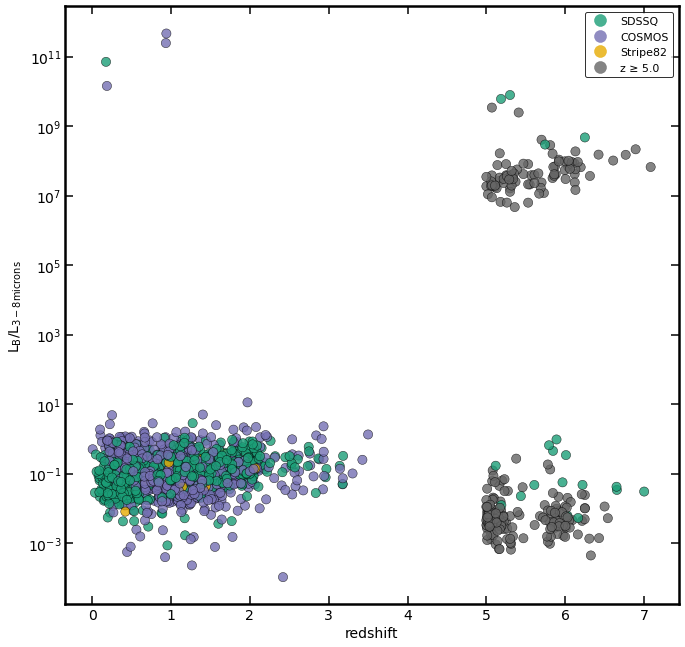

In [84]:
fig             = plt.figure(figsize=(11,11))
ax1             = fig.add_subplot(111)

plot_scatter_quotient(quot, col_a_q, col_b_q, ax1, filter_finite_q)

---

# Plot pairs of features and highlight their origin

We can also plot comparisons between features looking for eventual correlations.

In [85]:
col_a_s         = 'Luminosity 2.2-5.5 GHz'
col_b_s         = 'Luminosity 1.4-1.7 GHz'
common_vals_s   = np.multiply(lums_erg_s_df[col_a_s], lums_erg_s_df[col_b_s])
filter_finite_s = np.isfinite(common_vals_s)

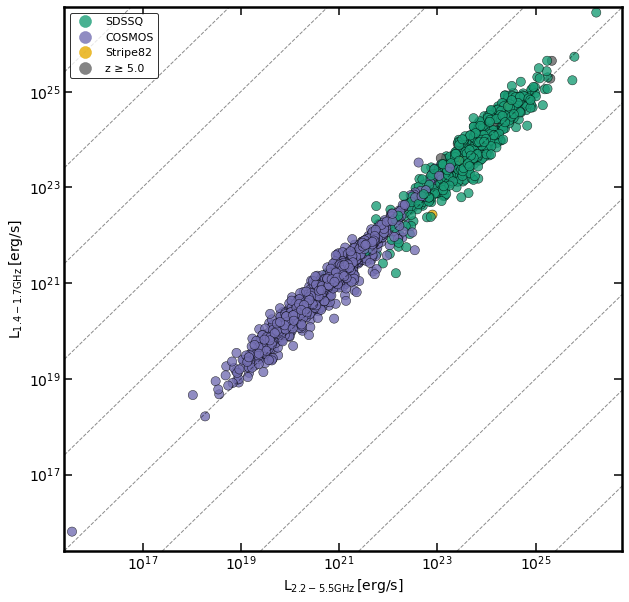

In [86]:
fig             = plt.figure(figsize=(10,10))
ax1             = fig.add_subplot(111)

plot_scatter_origin(col_a_s, col_b_s, ax1, filter_finite_s)

---

# Plot pairs of features with high correlation

The size of the markers (points) indicates the origin of the source (i.e., the survey they come from).  
The surveys have been described in the beginning of this notebook.

In [87]:
# orig_label_mod = {(0 + 2.5)**4:'FIRST+SDSS', (1 + 2.5)**4:'COSMOS+VLA', (2 + 2.5)**4:'Stripe82', (3 + 2.5)**4:'Inayoshi (z>5.5)'}
orig_label_mod = {(0 + 2.5)**4:'SDSSQ', (1 + 2.5)**4:'COSMOS', (2 + 2.5)**4:'Stripe82', (3 + 2.5)**4:'z \u2265 5.0'}

In [88]:
lum_names           = lums_erg_s_df.columns

In [89]:
add_histograms_flag = True  # Add histograms to the folowing plot

amp: 19.154, slope: 0.621
<x/y> = 4.427e-04
amp: 0.000, slope: 0.927
<y/x> = 2.259e+03


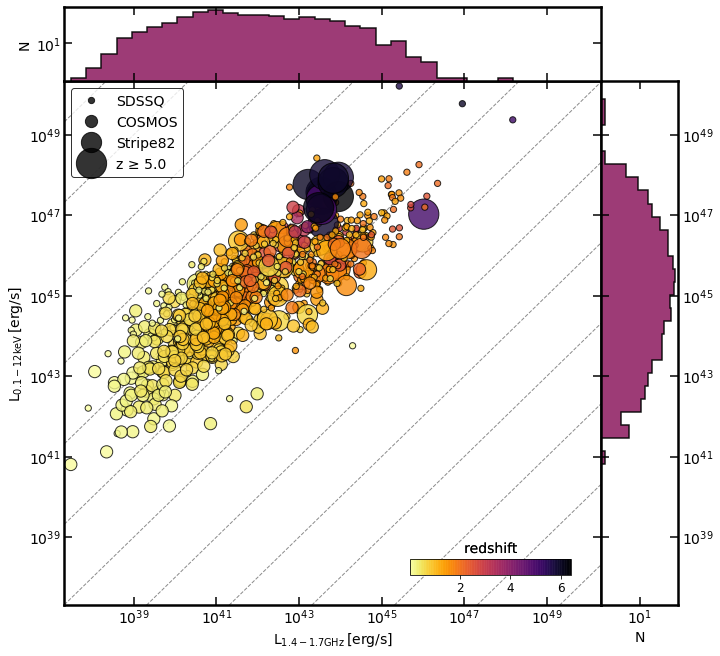

In [90]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by name
col_a         = "Luminosity 1.4-1.7 GHz"
col_b         = "Luminosity 0.1-12 keV"

clb = plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)
ax1.legend_._loc = 2
# plt.savefig('XRay_1_4GHz_' + today.strftime('%b_%d') + '_erg_s.pdf')

amp: 20.195, slope: 0.599
<x/y> = 3.066e-04
amp: 0.000, slope: 0.924
<y/x> = 3.262e+03


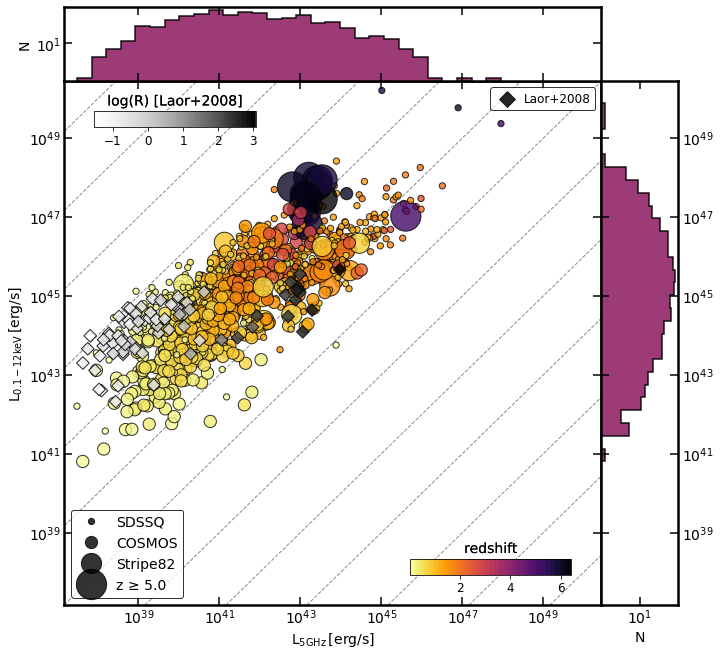

In [91]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)  

# Select columns by name
col_a         = "Luminosity 5 GHz"
col_b         = "Luminosity 0.1-12 keV"

clb_sample = plot_scatter_and_hist(col_a, col_b, ax1, ax2, ax3, add_histograms_flag)
# plt.savefig('XRay_5GHz_synth_' + today.strftime('%b_%d') + '_erg_s.pdf')

# laor_rq = ax1.scatter(10**laor_catalog_df['logL_R'][np.array(laor_catalog_df['logR']<=1)],\
#                       10**laor_catalog_df['logL_X'][np.array(laor_catalog_df['logR']<=1)], marker='o',\
#                       color='C0', s=80, ec='k', alpha=.85)
# laor_rl = ax1.scatter(10**laor_catalog_df['logL_R'][np.array(laor_catalog_df['logR']>1)],\
#                       10**laor_catalog_df['logL_X'][np.array(laor_catalog_df['logR']>1)], marker='o',\
#                       color='C2', s=80, ec='k', alpha=.85)

laor_sc = ax1.scatter(10**laor_catalog_df['logL_R'],\
                      10**laor_catalog_df['logL_X'], marker='D',\
                      c=laor_catalog_df['logR'], s=80, ec='k', alpha=.85, cmap='Greys',\
                      norm=MidpointNormalize(midpoint=1.0), plotnonfinite=True)

# Create colorbar and plot it
cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=2, borderpad=3) 
clb             = plt.colorbar(laor_sc, cax=cbaxes, orientation='horizontal')
clb.ax.tick_params(labelsize=12) 
# clb.set_label('redshift', size=14, path_effects=pe2)
clb.ax.set_title('log(R) [Laor+2008]', size=14, path_effects=pe2)

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**laor_catalog_df['logL_R'])]),\
                       np.nanmin([ymin, np.nanmin(10**laor_catalog_df['logL_X'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**laor_catalog_df['logL_R'])]),\
                       np.nanmax([ymax, np.nanmax(10**laor_catalog_df['logL_X'])])])
ax1.set_xlim(min_lim * 0.7, max_lim * 1.3)
ax1.set_ylim(min_lim * 0.7, max_lim * 1.3)

for val in range(16):
    ax1.lines.remove(ax1.lines[0])
# print(ax1.lines)

sample_leg      = ax1.get_legend()
sample_leg._loc = 3

laor_sc.set_color('k')
ax1.legend((laor_sc,), ('Laor+2008',), loc=1, prop={'size': 12}, edgecolor='k',\
               markerscale=1.25, scatterpoints=1, handletextpad=0.4);
ax1.add_artist(sample_leg)

# Add 1-1 line and parallels for comparison
add_parallel_lines(ax1, min_lim, max_lim)
# ax1.legend_._loc = 3
# plt.savefig('XRay_5GHz_synth_Laor_' + today.strftime('%b_%d') + '_erg_s.pdf')

amp: 20.195, slope: 0.599
<x/y> = 3.066e-04
amp: 0.000, slope: 0.924
<y/x> = 3.262e+03


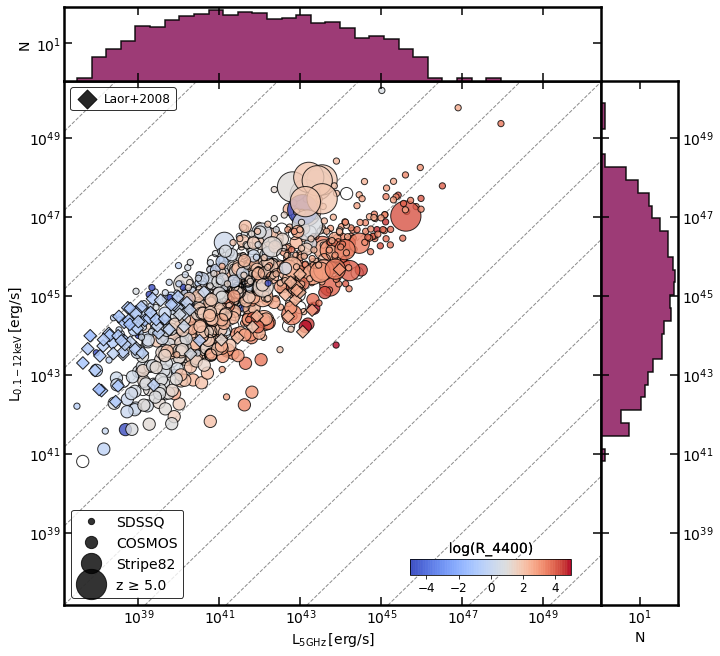

In [92]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)  

# Select columns by name
col_a         = "Luminosity 5 GHz"
col_b         = "Luminosity 0.1-12 keV"

clb_sample = plot_scatter_and_hist_R(col_a, col_b, ax1, ax2, ax3, '4400', add_histograms_flag)
# plt.savefig('XRay_5GHz_synth_' + today.strftime('%b_%d') + '_erg_s.pdf')

# laor_rq = ax1.scatter(10**laor_catalog_df['logL_R'][np.array(laor_catalog_df['logR']<=1)],\
#                       10**laor_catalog_df['logL_X'][np.array(laor_catalog_df['logR']<=1)], marker='o',\
#                       color='C0', s=80, ec='k', alpha=.85)
# laor_rl = ax1.scatter(10**laor_catalog_df['logL_R'][np.array(laor_catalog_df['logR']>1)],\
#                       10**laor_catalog_df['logL_X'][np.array(laor_catalog_df['logR']>1)], marker='o',\
#                       color='C2', s=80, ec='k', alpha=.85)
norm_R  = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=1.0)

laor_sc = ax1.scatter(10**laor_catalog_df['logL_R'],\
                      10**laor_catalog_df['logL_X'], marker='D',\
                      c=laor_catalog_df['logR'], s=80, ec='k', alpha=.85, cmap='coolwarm',\
                      norm=norm_R, plotnonfinite=True)

# Create colorbar and plot it
# cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=5, borderpad=3) 
# clb             = plt.colorbar(laor_sc, cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12) 
# # clb.set_label('redshift', size=14, path_effects=pe2)
# clb.ax.set_title('log(R) [Laor+2008]', size=14, path_effects=pe2)

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**laor_catalog_df['logL_R'])]),\
                       np.nanmin([ymin, np.nanmin(10**laor_catalog_df['logL_X'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**laor_catalog_df['logL_R'])]),\
                       np.nanmax([ymax, np.nanmax(10**laor_catalog_df['logL_X'])])])
ax1.set_xlim(min_lim * 0.7, max_lim * 1.3)
ax1.set_ylim(min_lim * 0.7, max_lim * 1.3)

for val in range(16):
    ax1.lines.remove(ax1.lines[0])
# print(ax1.lines)

sample_leg     = ax1.get_legend()
sample_leg._loc = 3

laor_sc.set_color('k')
ax1.legend((laor_sc,), ('Laor+2008',), loc=2, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);
ax1.add_artist(sample_leg)

# Add 1-1 line and parallels for comparison
add_parallel_lines(ax1, min_lim, max_lim)
#ax1.legend_._loc = 3
# plt.savefig('XRay_5GHz_synth_R_4400_high_z_Laor_' + today.strftime('%b_%d') + '_erg_s.pdf')

amp: 20.195, slope: 0.599
<x/y> = 3.066e-04
amp: 0.000, slope: 0.924
<y/x> = 3.262e+03


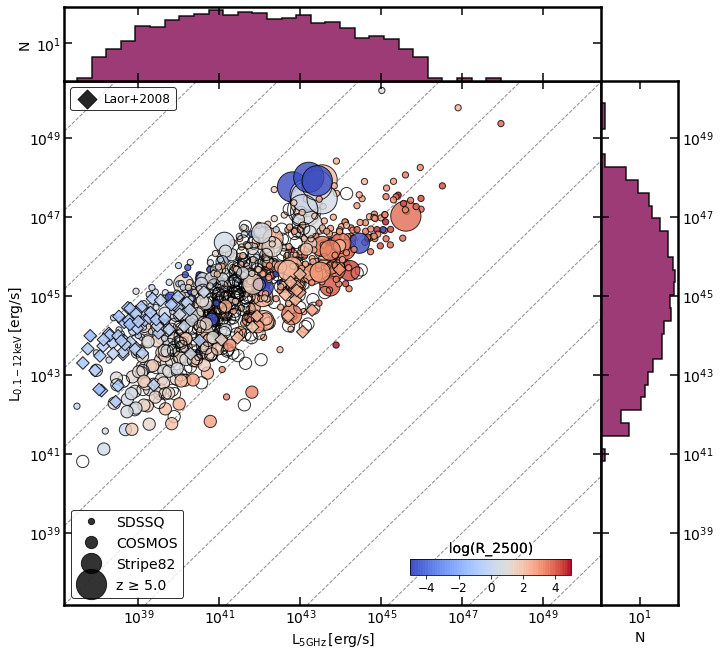

In [93]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)  

# Select columns by name
col_a        = "Luminosity 5 GHz"
col_b        = "Luminosity 0.1-12 keV"

clb_sample   = plot_scatter_and_hist_R(col_a, col_b, ax1, ax2, ax3, '2500', add_histograms_flag)
# plt.savefig('XRay_5GHz_synth_' + today.strftime('%b_%d') + '_erg_s.pdf')

norm_R       = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=1.0)

laor_sc = ax1.scatter(10**laor_catalog_df['logL_R'],\
                      10**laor_catalog_df['logL_X'], marker='D',\
                      c=laor_catalog_df['logR'], s=80, ec='k', alpha=.85, cmap='coolwarm',\
                      norm=norm_R, plotnonfinite=True)

# Create colorbar and plot it
# cbaxes          = inset_axes(ax1, width="30%", height="3%", loc=5, borderpad=3) 
# clb             = plt.colorbar(laor_sc, cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12) 
# # clb.set_label('redshift', size=14, path_effects=pe2)
# clb.ax.set_title('log(R) [Laor+2008]', size=14, path_effects=pe2)

xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**laor_catalog_df['logL_R'])]),\
                       np.nanmin([ymin, np.nanmin(10**laor_catalog_df['logL_X'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**laor_catalog_df['logL_R'])]),\
                       np.nanmax([ymax, np.nanmax(10**laor_catalog_df['logL_X'])])])
ax1.set_xlim(min_lim * 0.7, max_lim * 1.3)
ax1.set_ylim(min_lim * 0.7, max_lim * 1.3)

for val in range(16):
    ax1.lines.remove(ax1.lines[0])
# print(ax1.lines)

sample_leg      = ax1.get_legend()
sample_leg._loc = 3

laor_sc.set_color('k')
ax1.legend((laor_sc,), ('Laor+2008',), loc=2, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);
ax1.add_artist(sample_leg)

# Add 1-1 line and parallels for comparison
add_parallel_lines(ax1, min_lim, max_lim)
# ax1.legend_._loc = 3
# plt.savefig('XRay_5GHz_synth_R_2500_high_z_Laor_' + today.strftime('%b_%d') + '_erg_s.pdf')

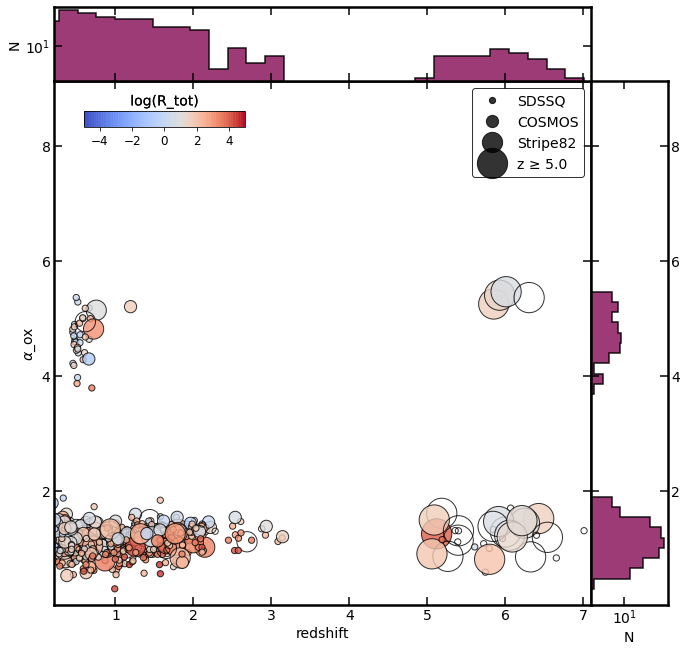

In [94]:
fig          = plt.figure(figsize=(11,11))

if not add_histograms_flag:
    ax1      = fig.add_subplot(111)

if add_histograms_flag:
    ax1      = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2      = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3      = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)  


clb_sample = plot_scatter_alpha_ox_2500_and_hist_R(ax1, ax2, ax3, 'tot', add_histograms_flag)
# plt.savefig('XRay_5GHz_synth_' + today.strftime('%b_%d') + '_erg_s.pdf')


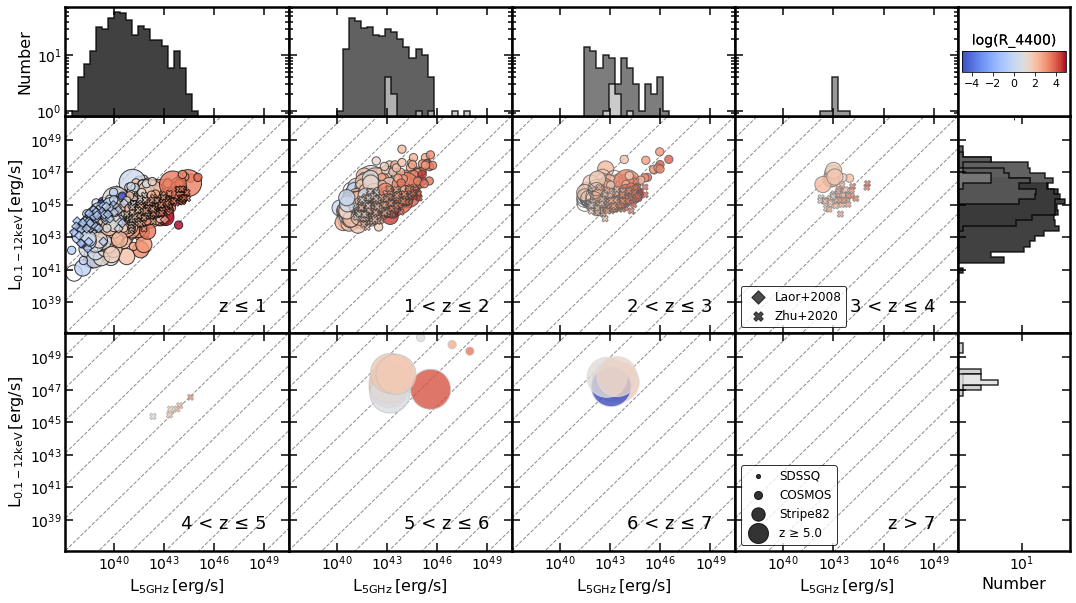

In [95]:
fig          = plt.figure(figsize=(18,10)) 

# Select columns by name
col_a         = "Luminosity 5 GHz"
col_b         = "Luminosity 0.1-12 keV"

clb_sample    = plot_scatter_R_zbins_hist(col_a, col_b, fig, '4400')
# plt.savefig('XRay_5GHz_R_4400_z_bin_' + today.strftime('%b_%d') + '_erg_s.pdf')

axes        = fig.axes
laor_sc     = {}
zhu_sc      = {}
filt_z_laor = {}
filt_z_zhu  = {}

vmin_R_4400 = np.nanmin([np.nanmin(laor_catalog_df['logR']), np.nanmin(zhu_catalog_df['log_R'])])
vmax_R_4400 = np.nanmax([np.nanmax(laor_catalog_df['logR']), np.nanmax(zhu_catalog_df['log_R'])])
# norm_R_4400 = MidpointNormalize(vmin=vmin_R_4400, vmax=vmax_R_4400, midpoint=1.0)
norm_R_4400 = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=1.0)


for z_bin in np.arange(8):
    filt_z_laor[z_bin] = np.array(laor_catalog_df['z'].values > z_bin)\
                                & np.array(laor_catalog_df['z'].values <= (z_bin + 1))
    filt_z_zhu[z_bin]  = np.array(zhu_catalog_df['z'].values > z_bin)\
                                & np.array(zhu_catalog_df['z'].values <= (z_bin + 1))
    laor_sc[z_bin]     = axes[z_bin].scatter(10**laor_catalog_df['logL_R'].values[filt_z_laor[z_bin]],\
                                             10**laor_catalog_df['logL_X'].values[filt_z_laor[z_bin]], marker='D',\
                                             c=laor_catalog_df['logR'].values[filt_z_laor[z_bin]], s=40,\
                                             ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_R_4400,\
                                             plotnonfinite=True)
    zhu_sc[z_bin]      = axes[z_bin].scatter(10**zhu_catalog_df['log_L_5GHz'].values[filt_z_zhu[z_bin]],\
                                             10**zhu_catalog_df['log_L_2keV'].values[filt_z_zhu[z_bin]], marker='X',\
                                             c=zhu_catalog_df['log_R'].values[filt_z_zhu[z_bin]], s=40,\
                                             ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_R_4400,\
                                             plotnonfinite=True)

# Create colorbar and plot it
# # cbaxes          = inset_axes(axes[7], width="30%", height="3%", loc=5, borderpad=3)
# cbaxes          = inset_axes(axes[13], width="85%", height="10%", loc=8, borderpad=3)
# clb             = plt.colorbar(laor_sc[0], cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12) 
# # clb.set_label('redshift', size=14, path_effects=pe2)
# clb.ax.set_title('log(R_4400)\n[Laor+2008,\nZhu+2020]', size=12, path_effects=pe2)

xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**laor_catalog_df['logL_R']), np.nanmin(10**zhu_catalog_df['log_L_5GHz'])]),\
                       np.nanmin([ymin, np.nanmin(10**laor_catalog_df['logL_X']), np.nanmin(10**zhu_catalog_df['log_L_2keV'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**laor_catalog_df['logL_R']), np.nanmax(10**zhu_catalog_df['log_L_5GHz'])]),\
                       np.nanmax([ymax, np.nanmax(10**laor_catalog_df['logL_X']), np.nanmax(10**zhu_catalog_df['log_L_2keV'])])])
axes[0].set_xlim(min_lim * 0.7, max_lim * 1.3)
axes[0].set_ylim(min_lim * 0.7, max_lim * 1.3)

for ax_idx in np.arange(8):
    # Remove old diagonal lines
    for val in range(16):
        axes[ax_idx].lines.remove(axes[ax_idx].lines[0])
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(axes[ax_idx], min_lim, max_lim)
    # axes[ax_idx].legend_._loc = 3

laor_sc[0].set_color('k')
zhu_sc[0].set_color('k')
axes[3].legend((laor_sc[0], zhu_sc[0]), ('Laor+2008', 'Zhu+2020'), loc=3, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);
# plt.savefig('XRay_5GHz_R_4400_z_bin_Laor_Zhu_' + today.strftime('%b_%d') + '_erg_s.pdf')

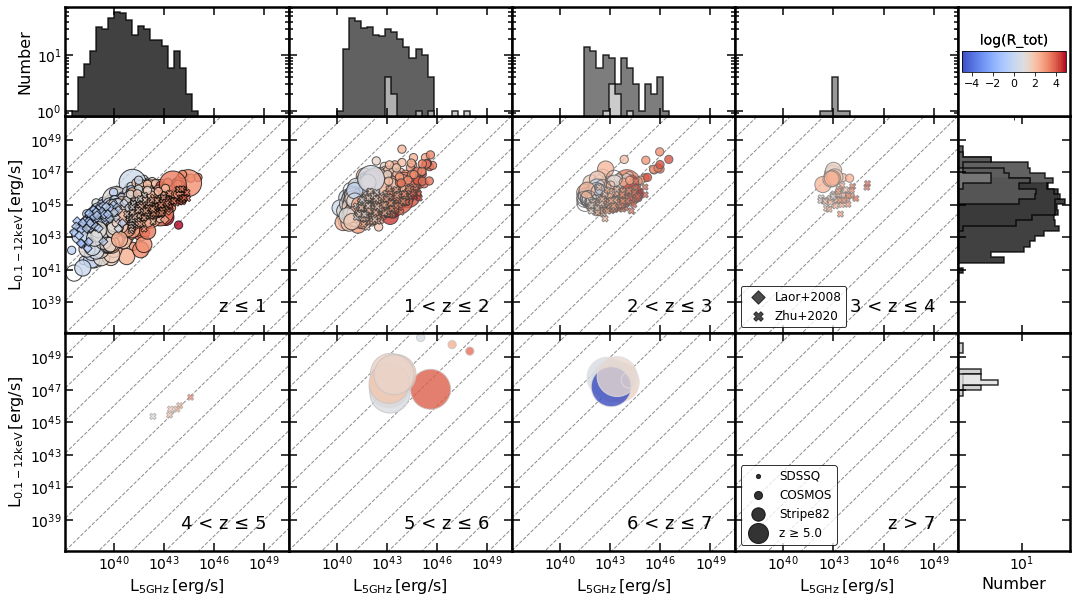

In [96]:
fig         = plt.figure(figsize=(18,10)) 

# Select columns by name
col_a       = "Luminosity 5 GHz"
col_b       = "Luminosity 0.1-12 keV"

clb_sample  = plot_scatter_R_zbins_hist(col_a, col_b, fig, 'tot')
# plt.savefig('XRay_5GHz_R_4400_tot_z_bin_' + today.strftime('%b_%d') + '_erg_s.pdf')

axes        = fig.axes
laor_sc     = {}
zhu_sc      = {}
filt_z_laor = {}
filt_z_zhu  = {}

vmin_R_4400 = np.nanmin([np.nanmin(laor_catalog_df['logR']), np.nanmin(zhu_catalog_df['log_R'])])
vmax_R_4400 = np.nanmax([np.nanmax(laor_catalog_df['logR']), np.nanmax(zhu_catalog_df['log_R'])])
# norm_R_4400 = MidpointNormalize(vmin=vmin_R_4400, vmax=vmax_R_4400, midpoint=1.0)
# norm_R_4400 = MidpointNormalize(vmin=-5., vmax=5., midpoint=1.0)
norm_R_4400 = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=1.0)

for z_bin in np.arange(8):
    filt_z_laor[z_bin] = np.array(laor_catalog_df['z'].values > z_bin)\
                                & np.array(laor_catalog_df['z'].values <= (z_bin + 1))
    filt_z_zhu[z_bin]  = np.array(zhu_catalog_df['z'].values > z_bin)\
                                & np.array(zhu_catalog_df['z'].values <= (z_bin + 1))
    laor_sc[z_bin] = axes[z_bin].scatter(10**laor_catalog_df['logL_R'].values[filt_z_laor[z_bin]],\
                                         10**laor_catalog_df['logL_X'].values[filt_z_laor[z_bin]], marker='D',\
                                         c=laor_catalog_df['logR'].values[filt_z_laor[z_bin]], s=40,\
                                         ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_R_4400,\
                                         plotnonfinite=True)
    zhu_sc[z_bin]  = axes[z_bin].scatter(10**zhu_catalog_df['log_L_5GHz'].values[filt_z_zhu[z_bin]],\
                                         10**zhu_catalog_df['log_L_2keV'].values[filt_z_zhu[z_bin]], marker='X',\
                                         c=zhu_catalog_df['log_R'].values[filt_z_zhu[z_bin]], s=40,\
                                         ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_R_4400,\
                                         plotnonfinite=True)

# Create colorbar and plot it
# # cbaxes          = inset_axes(axes[7], width="30%", height="3%", loc=5, borderpad=3)
# cbaxes          = inset_axes(axes[13], width="85%", height="10%", loc=8, borderpad=3)
# clb             = plt.colorbar(laor_sc[0], cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12) 
# # clb.set_label('redshift', size=14, path_effects=pe2)
# clb.ax.set_title('log(R_4400)\n[Laor+2008,\nZhu+2020]', size=12, path_effects=pe2)

xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**laor_catalog_df['logL_R'])]),\
                       np.nanmin([ymin, np.nanmin(10**laor_catalog_df['logL_X'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**laor_catalog_df['logL_R'])]),\
                       np.nanmax([ymax, np.nanmax(10**laor_catalog_df['logL_X'])])])
axes[0].set_xlim(min_lim * 0.7, max_lim * 1.3)
axes[0].set_ylim(min_lim * 0.7, max_lim * 1.3)

for ax_idx in np.arange(8):
    # Remove old diagonal lines
    for val in range(16):
        axes[ax_idx].lines.remove(axes[ax_idx].lines[0])
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(axes[ax_idx], min_lim, max_lim)
    # axes[ax_idx].legend_._loc = 3
laor_sc[0].set_color('k')
zhu_sc[0].set_color('k')
axes[3].legend((laor_sc[0], zhu_sc[0]), ('Laor+2008', 'Zhu+2020'), loc=3, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);
# plt.savefig('XRay_5GHz_R_4400_tot_z_bin_Laor_Zhu_' + today.strftime('%b_%d') + '_erg_s.pdf')

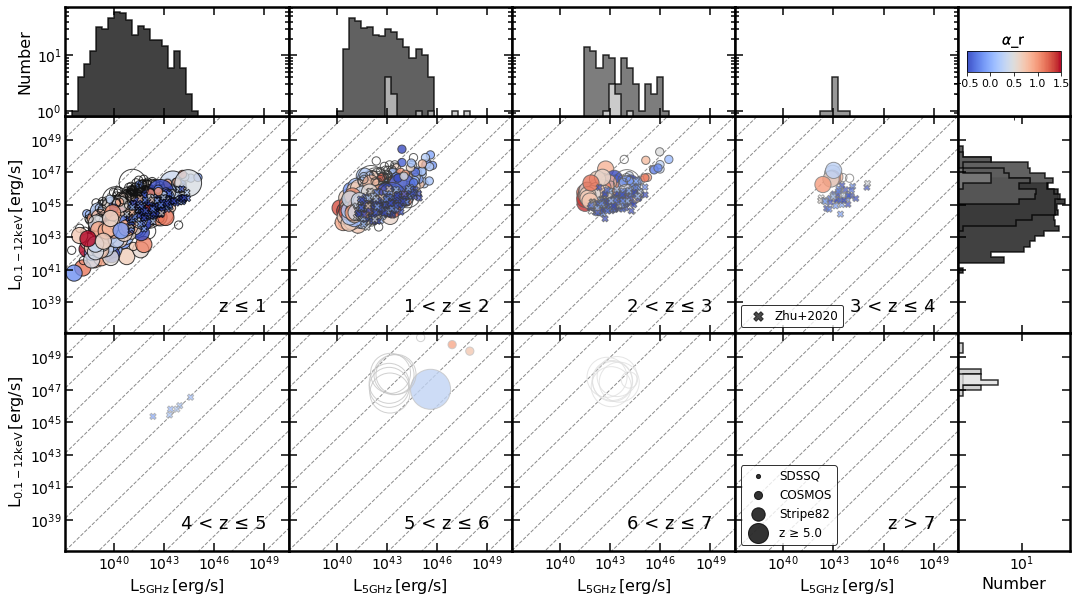

In [103]:
fig         = plt.figure(figsize=(18,10)) 

# Select columns by name
col_a       = "Luminosity 5 GHz"
col_b       = "Luminosity 0.1-12 keV"

clb_sample  = plot_scatter_alpha_r_zbins_hist(col_a, col_b, fig)
# plt.savefig('XRay_5GHz_alpha_r_z_bin_' + today.strftime('%b_%d') + '_erg_s.pdf')

axes        = fig.axes
zhu_sc      = {}
filt_z_zhu  = {}

vmin_alpha_r = np.nanmin(zhu_catalog_df['alphs_r'])
vmax_alpha_r = np.nanmax(zhu_catalog_df['alphs_r'])
# norm_alpha_r = MidpointNormalize(vmin=vmin_alpha_r, vmax=vmax_alpha_r, midpoint=0.5)
# norm_alpha_r = MidpointNormalize(vmin=-0.5, vmax=1.5, midpoint=0.5)
norm_alpha_r = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=0.5)

for z_bin in np.arange(8):
    filt_z_zhu[z_bin]  = np.array(zhu_catalog_df['z'].values > z_bin)\
                                & np.array(zhu_catalog_df['z'].values <= (z_bin + 1))
    zhu_sc[z_bin]  = axes[z_bin].scatter(10**zhu_catalog_df['log_L_5GHz'].values[filt_z_zhu[z_bin]],\
                                         10**zhu_catalog_df['log_L_2keV'].values[filt_z_zhu[z_bin]], marker='X',\
                                         c=zhu_catalog_df['alphs_r'].values[filt_z_zhu[z_bin]], s=40,\
                                         ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_alpha_r,\
                                         plotnonfinite=True)

# Create colorbar and plot it. Use only one colorbar
# cbaxes          = inset_axes(axes[13], width="85%", height="10%", loc=8, borderpad=3)
# clb             = plt.colorbar(zhu_sc[0], cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12)
# clb.set_ticks([-0.5, 0.0, 0.5, 1.0, 1.5])
# # clb.set_ticklabels([mn,md,mx])
# clb.ax.set_title(f'{alp_str}\n[Zhu+2020]', size=12, path_effects=pe2)
# print(clb.vmax)

xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**zhu_catalog_df['log_L_5GHz'])]),\
                       np.nanmin([ymin, np.nanmin(10**zhu_catalog_df['log_L_2keV'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**zhu_catalog_df['log_L_5GHz'])]),\
                       np.nanmax([ymax, np.nanmax(10**zhu_catalog_df['log_L_2keV'])])])
axes[0].set_xlim(min_lim * 0.7, max_lim * 1.3)
axes[0].set_ylim(min_lim * 0.7, max_lim * 1.3)

for ax_idx in np.arange(8):
    # Remove old diagonal lines
    for val in range(16):
        axes[ax_idx].lines.remove(axes[ax_idx].lines[0])
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(axes[ax_idx], min_lim, max_lim)
    # axes[ax_idx].legend_._loc = 3
zhu_sc[0].set_color('k')
axes[3].legend((zhu_sc[0], ), ('Zhu+2020',), loc=3, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);
# plt.savefig('XRay_5GHz_alpha_r_z_bin_Zhu_' + today.strftime('%b_%d') + '_erg_s.pdf')

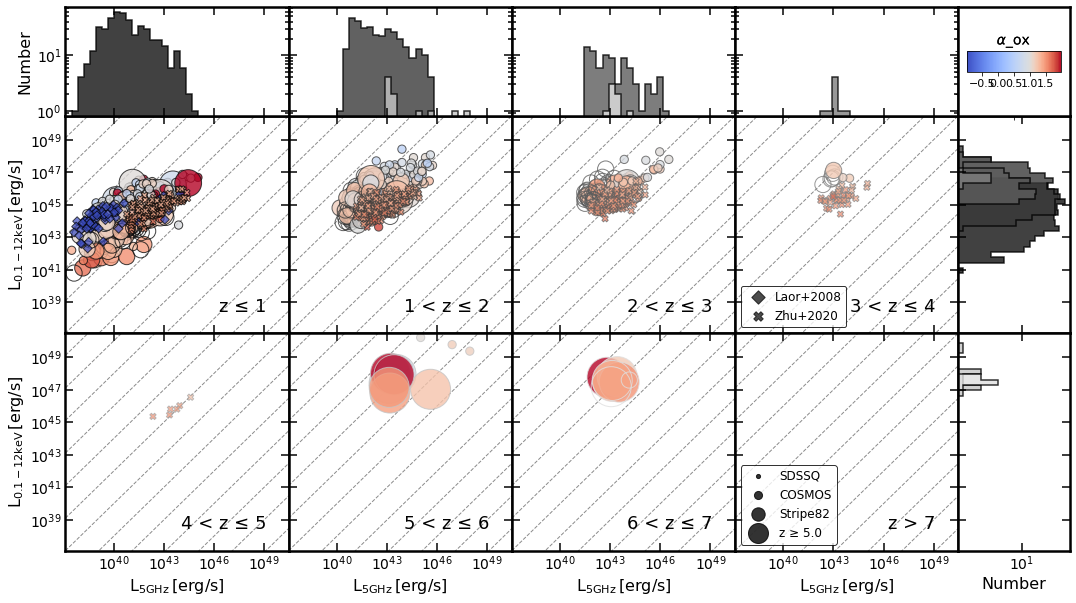

In [105]:
fig          = plt.figure(figsize=(18,10)) 

# Select columns by name
col_a        = "Luminosity 5 GHz"
col_b        = "Luminosity 0.1-12 keV"

clb_sample   = plot_scatter_alpha_ox_zbins_hist(col_a, col_b, fig)
# plt.savefig('XRay_5GHz_alpha_ox_z_bin_' + today.strftime('%b_%d') + '_erg_s.pdf')

axes         = fig.axes
laor_sc      = {}
filt_z_laor  = {}

vmin_alpha_ox = np.nanmin([np.nanmin(laor_catalog_df['alpha_ox']), np.nanmin(zhu_catalog_df['alpha_ox'])])
vmax_alpha_ox = np.nanmax([np.nanmax(laor_catalog_df['alpha_ox']), np.nanmax(zhu_catalog_df['alpha_ox'])])
# norm_alpha_r = MidpointNormalize(vmin=vmin_alpha_r, vmax=vmax_alpha_r, midpoint=1.0)
# norm_alpha_r = MidpointNormalize(vmin=-1.0, vmax=2.0, midpoint=1.0)
# norm_alpha_r = MidpointNormalize(vmin=-0.5, vmax=1.5, midpoint=0.5)
norm_alpha_ox = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=0.5)

for z_bin in np.arange(8):
    filt_z_laor[z_bin]  = np.array(laor_catalog_df['z'].values > z_bin)\
                                & np.array(laor_catalog_df['z'].values <= (z_bin + 1))
    filt_z_zhu[z_bin]   = np.array(zhu_catalog_df['z'].values > z_bin)\
                                & np.array(zhu_catalog_df['z'].values <= (z_bin + 1))
    laor_sc[z_bin]  = axes[z_bin].scatter(10**laor_catalog_df['logL_R'].values[filt_z_laor[z_bin]],\
                                         10**laor_catalog_df['logL_X'].values[filt_z_laor[z_bin]], marker='D',\
                                         c=laor_catalog_df['alpha_ox'].values[filt_z_laor[z_bin]], s=40,\
                                         ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_alpha_ox,\
                                         plotnonfinite=True)
    zhu_sc[z_bin]  = axes[z_bin].scatter(10**zhu_catalog_df['log_L_5GHz'].values[filt_z_zhu[z_bin]],\
                                         10**zhu_catalog_df['log_L_2keV'].values[filt_z_zhu[z_bin]], marker='X',\
                                         c=zhu_catalog_df['alpha_ox'].values[filt_z_zhu[z_bin]], s=40,\
                                         ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_alpha_ox,\
                                         plotnonfinite=True)

# Create colorbar and plot it. Use only one colorbar
# cbaxes          = inset_axes(axes[13], width="85%", height="10%", loc=8, borderpad=3)
# clb             = plt.colorbar(laor_sc[0], cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12)
# # clb.set_ticks([-0.5, 0.0, 0.5, 1.0, 1.5])
# # clb.set_ticklabels([mn,md,mx])
# clb.ax.set_title(f'{alp_str}\n[Laor+2008\nZhu+2020]', size=12, path_effects=pe2)
# # print(clb.vmax)

xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**laor_catalog_df['logL_R'])]),\
                       np.nanmin([ymin, np.nanmin(10**laor_catalog_df['logL_X'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**laor_catalog_df['logL_R'])]),\
                       np.nanmax([ymax, np.nanmax(10**laor_catalog_df['logL_X'])])])
axes[0].set_xlim(min_lim * 0.7, max_lim * 1.3)
axes[0].set_ylim(min_lim * 0.7, max_lim * 1.3)

for ax_idx in np.arange(8):
    # Remove old diagonal lines
    for val in range(16):
        axes[ax_idx].lines.remove(axes[ax_idx].lines[0])
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(axes[ax_idx], min_lim, max_lim)
    # axes[ax_idx].legend_._loc = 3
zhu_sc[0].set_color('k')
laor_sc[0].set_color('k')
axes[3].legend((laor_sc[0], zhu_sc[0]), ('Laor+2008', 'Zhu+2020'), loc=3, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);
# plt.savefig('XRay_5GHz_alpha_ox_z_bin_Laor_Zhu_' + today.strftime('%b_%d') + '_erg_s.pdf')

(1e+41, 1e+49)

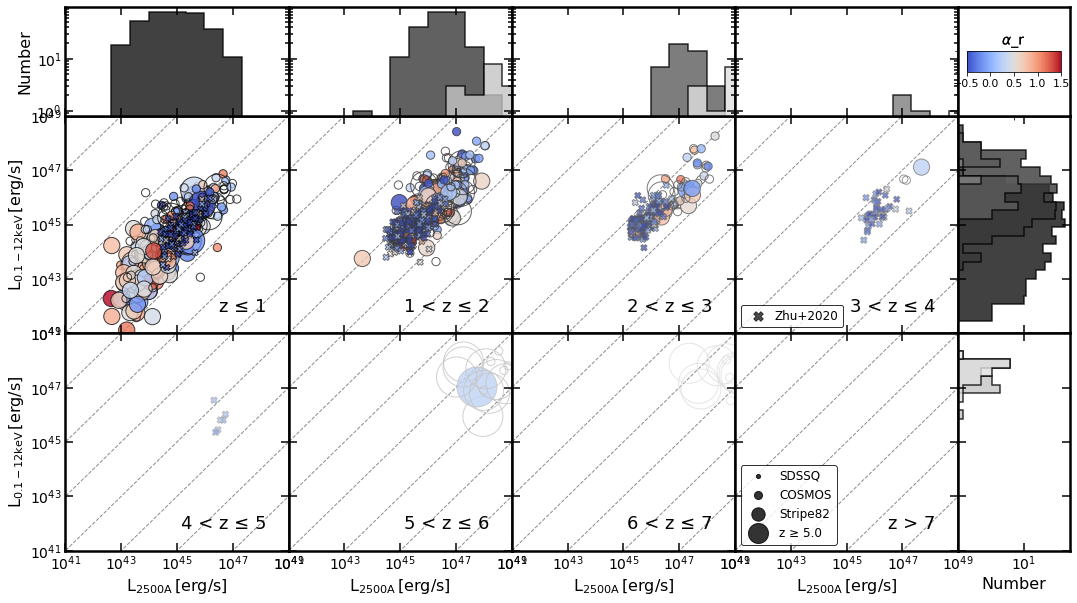

In [99]:
fig         = plt.figure(figsize=(18,10)) 

# Select columns by name
col_a       = "Luminosity 2500 A"
col_b       = "Luminosity 0.1-12 keV"

clb_sample  = plot_scatter_alpha_r_zbins_hist(col_a, col_b, fig)
# plt.savefig('XRay_2500A_alpha_r_z_bin_' + today.strftime('%b_%d') + '_erg_s.pdf')

axes        = fig.axes
zhu_sc      = {}
filt_z_zhu  = {}

vmin_alpha_r = np.nanmin(zhu_catalog_df['alphs_r'])
vmax_alpha_r = np.nanmax(zhu_catalog_df['alphs_r'])
# norm_alpha_r = MidpointNormalize(vmin=vmin_alpha_r, vmax=vmax_alpha_r, midpoint=0.5)
# norm_alpha_r = MidpointNormalize(vmin=-0.5, vmax=1.5, midpoint=0.5)
norm_alpha_r = MidpointNormalize(vmin=clb_sample.vmin, vmax=clb_sample.vmax, midpoint=0.5)

for z_bin in np.arange(8):
    filt_z_zhu[z_bin]  = np.array(zhu_catalog_df['z'].values > z_bin)\
                                & np.array(zhu_catalog_df['z'].values <= (z_bin + 1))
    zhu_sc[z_bin]  = axes[z_bin].scatter(10**zhu_catalog_df['log_L_2500'].values[filt_z_zhu[z_bin]],\
                                         10**zhu_catalog_df['log_L_2keV'].values[filt_z_zhu[z_bin]], marker='X',\
                                         c=zhu_catalog_df['alphs_r'].values[filt_z_zhu[z_bin]], s=40,\
                                         ec=colors_8_alt_2[z_bin], alpha=.70, cmap='coolwarm', norm=norm_alpha_r,\
                                         plotnonfinite=True)

# Create colorbar and plot it. Use only one colorbar
# cbaxes          = inset_axes(axes[13], width="85%", height="10%", loc=8, borderpad=3)
# clb             = plt.colorbar(zhu_sc[0], cax=cbaxes, orientation='horizontal')
# clb.ax.tick_params(labelsize=12)
# clb.set_ticks([-0.5, 0.0, 0.5, 1.0, 1.5])
# # clb.set_ticklabels([mn,md,mx])
# clb.ax.set_title(f'{alp_str}\n[Zhu+2020]', size=12, path_effects=pe2)
# print(clb.vmax)

xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[0].get_ylim()
min_lim    = np.nanmin([np.nanmin([xmin, np.nanmin(10**zhu_catalog_df['log_L_2500'])]),\
                       np.nanmin([ymin, np.nanmin(10**zhu_catalog_df['log_L_2keV'])])])
max_lim    = np.nanmax([np.nanmax([xmax, np.nanmax(10**zhu_catalog_df['log_L_2500'])]),\
                       np.nanmax([ymax, np.nanmax(10**zhu_catalog_df['log_L_2keV'])])])
axes[0].set_xlim(min_lim * 0.7, max_lim * 1.3)
axes[0].set_ylim(min_lim * 0.7, max_lim * 1.3)

# axes[0].set_xlim(1e38, 1e49)
# axes[0].set_ylim(1e38, 1e49)

for ax_idx in np.arange(8):
    # Remove old diagonal lines
    for val in range(16):
        axes[ax_idx].lines.remove(axes[ax_idx].lines[0])
    # Add 1-1 line and parallels for comparison
    add_parallel_lines(axes[ax_idx], min_lim, max_lim)
    # axes[ax_idx].legend_._loc = 3
zhu_sc[0].set_color('k')
axes[3].legend((zhu_sc[0], ), ('Zhu+2020',), loc=3, prop={'size': 12}, edgecolor='k',\
               markerscale=1.5, scatterpoints=1, handletextpad=0.4);

axes[0].set_xlim(1e41, 1e49)
axes[0].set_ylim(1e41, 1e49)
# plt.savefig('XRay_2500A_alpha_r_z_bin_Zhu_' + today.strftime('%b_%d') + '_erg_s.pdf')

---

# Generate SED plot for individual sources

In [100]:
np.unique(counts_df.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [101]:
source_idx = np.where(counts_df.values == np.nanmax(counts_df.values))[0][0]
# source_idx = 10124
source_z   = redshift_df.iloc[source_idx]

NameError: name 'orig_names' is not defined

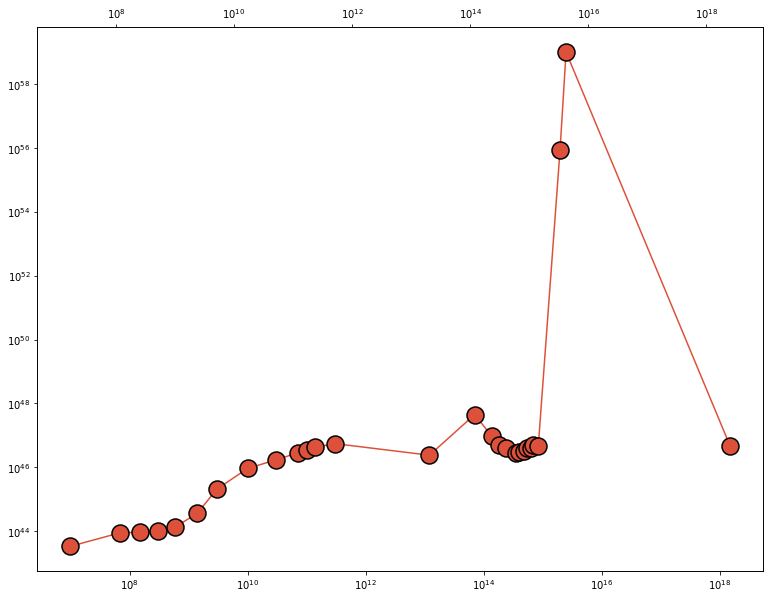

In [102]:
fig        = plt.figure(figsize=(13,10))
ax1        = fig.add_subplot(111)

plot_sed_source(source_idx, source_z, ax1)